### Импортим библиотеки

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from python_modules import preprocess
from python_modules import visualization
%matplotlib inline
pd.set_option('chained_assignment',None)

### Считываем датасет

| Поле                          | Тип данных         | Описание                                                         |
|-------------------------------|--------------------|------------------------------------------------------------------|
| premium                       | bool               | Является ли данная вакансия премиум-вакансией                    |
| department                    | object             | Департамент                                                      |
| has_test                      | bool               | Информация о наличии прикрепленного тестового задания к вакансии |
| response_letter_required      | bool               | Обязательно ли заполнять сообщение при отклике на вакансию       |
| salary                        | object             | Зарплата                                                         |
| archived                      | bool               | Лежит ли вакансия в архиве                                       |
| schedule                      | object             | График работы                                                    |
| working_days                  | list(object)       | Список рабочих дней                                              |
| working_time_intervals        | list(object)       | Список с временными интервалами работы                           |
| working_time_modes            | list(object)       | Список режимов времени работы                                    |
| accept_temporary              | bool               | Указание, что вакансия доступна с временным трудоустройством     |
| accept_incomplete_resumes     | bool               | Разрешен ли отклик на вакансию неполным резюме                   |
| experience                    | object             | Опыт работы                                                      |
| employment                    | object             | Тип занятости                                                    |
| is_adv_vacancy                | bool               | Является ли вакансия рекламной                                   |
| employer_trusted              | bool               | Флаг, показывающий, прошла ли компания проверку на сайте         |
| employer_type                 | object             | Тип нанимателя                                                   |
| industries_count              | int                | Количеcтво индустрий работодателя                                |
| vacancies_count               | int                | Количество открытых вакансий у работодателя                      |
| has_email                     | bool               | Имеет ли компания mail для связи                                 |
| number_phones                 | int                | Количество телефонов для связи с работодателем                   |
| vacancy_type                  | object             | Тип вакансии                                                     |
| lat                           | float64            | Широта                                                           |
| lon                           | float64            | Долгота                                                          |
| industry                      | object             | Отрасль компании                                                 |

In [2]:
# скачиваем датасет и добавляем признак, ответственный за принадлежность к отрасли
datasets = []
for filename in os.listdir("datasets"):
   with open(os.path.join("datasets/", filename), 'r', encoding='utf-8') as f:
       df = pd.read_json(f, encoding='utf-8')
       df['industry'] = np.full(df.shape[0], filename)
       df['industry'] = df['industry'].apply(lambda x: x[9:-6])
       datasets.append(df)


In [3]:
datasets[0].head()

,premium,department,has_test,response_letter_required,salary,archived,schedule,working_days,working_time_intervals,working_time_modes,...,employer_trusted,employer_type,industries_count,vacancies_count,has_email,phones_count,vacancy_type,lat,lon,industry
0,False,None,False,False,"{'from': 70000, 'to': 110000, 'currency': 'RUR...",False,Полный день,[],[],[],...,True,agency,5.0,5.0,False,0,Открытая,55.947485,37.310681,Автомобильный бизнес
1,False,None,False,False,"{'from': 150000, 'to': None, 'currency': 'RUR'...",False,Сменный график,[],[],[],...,True,company,3.0,42.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес
2,False,None,False,False,"{'from': 35000, 'to': 40000, 'currency': 'RUR'...",False,Удаленная работа,[],[],[],...,False,project_director,1.0,2.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес
3,False,None,False,False,"{'from': 75000, 'to': None, 'currency': 'RUR',...",False,Сменный график,[],[],[],...,True,company,5.0,30.0,False,0,Открытая,55.794922,37.651583,Автомобильный бизнес
4,False,None,False,False,"{'from': 120000, 'to': 350000, 'currency': 'RU...",False,Полный день,[],[],[],...,True,company,5.0,16.0,False,0,Открытая,55.709825,37.937480,Автомобильный бизнес


Теперь надо сделать препроцесс признаков.

### Предварительная обработка

In [4]:
# смотрим какие колонки заполнены и в каких есть пропущенные значения
for dataset in datasets:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9253 entries, 0 to 9252
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   premium                    9253 non-null   bool   
 1   department                 442 non-null    object 
 2   has_test                   9253 non-null   bool   
 3   response_letter_required   9253 non-null   bool   
 4   salary                     9253 non-null   object 
 5   archived                   9253 non-null   bool   
 6   schedule                   9253 non-null   object 
 7   working_days               9253 non-null   object 
 8   working_time_intervals     9253 non-null   object 
 9   working_time_modes         9253 non-null   object 
 10  accept_temporary           9253 non-null   bool   
 11  professional_roles         9253 non-null   object 
 12  accept_incomplete_resumes  9253 non-null   bool   
 13  experience                 9253 non-null   objec

Видно, что поле `department` имеет малое количество вакансий, значит надо избавиться от него. Поля `lat`, `lon`, `employer_type`, `industries_count`, `vacancies_count` имеют пропущенные значения

In [5]:
# убираем признак департамент
for dataset in datasets:
    dataset.drop(columns=["department"], inplace=True)

In [6]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,archived,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,...,employer_trusted,employer_type,industries_count,vacancies_count,has_email,phones_count,vacancy_type,lat,lon,industry
0,False,False,False,"{'from': 70000, 'to': 110000, 'currency': 'RUR...",False,Полный день,[],[],[],False,...,True,agency,5.0,5.0,False,0,Открытая,55.947485,37.310681,Автомобильный бизнес
1,False,False,False,"{'from': 150000, 'to': None, 'currency': 'RUR'...",False,Сменный график,[],[],[],False,...,True,company,3.0,42.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес
2,False,False,False,"{'from': 35000, 'to': 40000, 'currency': 'RUR'...",False,Удаленная работа,[],[],[],False,...,False,project_director,1.0,2.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес
3,False,False,False,"{'from': 75000, 'to': None, 'currency': 'RUR',...",False,Сменный график,[],[],[],False,...,True,company,5.0,30.0,False,0,Открытая,55.794922,37.651583,Автомобильный бизнес
4,False,False,False,"{'from': 120000, 'to': 350000, 'currency': 'RU...",False,Полный день,[],[],[],False,...,True,company,5.0,16.0,False,0,Открытая,55.709825,37.937480,Автомобильный бизнес


Так колонка `salary` имеет границы зарплаты и тип зарпалаты: до вычета налогов или после.
Также `professional_roles` содержит профессиональные роли, указанные в вакансии, оставим только первую указанную роль, считая, что она является главной.

In [7]:
# упрощение столбцов и сохранение атомарных признаков
for dataset in datasets:
    dataset["salary"] = dataset["salary"].apply(preprocess.get_net_salary)
    dataset["professional_roles"] = dataset["professional_roles"].apply(lambda x: x[0]["name"])

Важным параметром, в теории, могут являться станции метро находящиеся близко. Для этого нужно считать их из сохраненного файла, полученного при помощи парсера. А также, посчитать две новые переменные: расстояние до ближайшей станции и количество станций в радиусе километра, ведь километр это оптимальное расстояние, которое можно пройти за 10 минут (из личного опыта, не включая режим "турбо-походки").

In [8]:
# считывание станций метро в Москве
stations = np.load("src_files/stations.npy")

In [9]:
# получение признаков из геопозиции: количество ближайших станций и расстояние до ближайшей станции.
for dataset in datasets:
    dataset[["stations_within_km", "distance_to_the_nearest(m)"]] = dataset[["lat", "lon"]].apply(lambda row: pd.Series(preprocess.get_stations_count_and_distance_to_nearest(row, stations)), axis=1)

In [10]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,archived,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,...,industries_count,vacancies_count,has_email,phones_count,vacancy_type,lat,lon,industry,stations_within_km,distance_to_the_nearest(m)
0,False,False,False,90000.0,False,Полный день,[],[],[],False,...,5.0,5.0,False,0,Открытая,55.947485,37.310681,Автомобильный бизнес,1.0,792.486649
1,False,False,False,130500.0,False,Сменный график,[],[],[],False,...,3.0,42.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес,NaN,NaN
2,False,False,False,37500.0,False,Удаленная работа,[],[],[],False,...,1.0,2.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес,NaN,NaN
3,False,False,False,75000.0,False,Сменный график,[],[],[],False,...,5.0,30.0,False,0,Открытая,55.794922,37.651583,Автомобильный бизнес,2.0,808.908176
4,False,False,False,235000.0,False,Полный день,[],[],[],False,...,5.0,16.0,False,0,Открытая,55.709825,37.937480,Автомобильный бизнес,0.0,1037.894289


Есть 3 колонки, которые могут быть очень полезны для анализа, но достаточно ли там непустых значений?

In [11]:
for dataset in datasets:
    print(dataset['industry'][0])
    tot_count = dataset.shape[0]
    empty_working_days_count = dataset['working_days'].apply(lambda x: len(x) == 0).sum()
    empty_working_intervals_count = dataset['working_time_intervals'].apply(lambda x: len(x) == 0).sum()
    empty_working_time_modes_count = dataset['working_time_modes'].apply(lambda x: len(x) == 0).sum()
    print("\tОтношение пустых значений ко всем значениям")
    print(f"\tworking_days: {empty_working_days_count/tot_count}")
    print(f"\tworking_time_intervals: {empty_working_intervals_count/tot_count}")
    print(f"\tworking_time_modes: {empty_working_time_modes_count/tot_count}")

Автомобильный бизнес
	Отношение пустых значений ко всем значениям
	working_days: 0.9974062466227169
	working_time_intervals: 0.993191397384632
	working_time_modes: 0.9955690046471415
Перевозки, логистика, склад, ВЭД
	Отношение пустых значений ко всем значениям
	working_days: 0.93408951563458
	working_time_intervals: 0.8710913549969344
	working_time_modes: 0.884886572654813
Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
	Отношение пустых значений ко всем значениям
	working_days: 0.9988668555240793
	working_time_intervals: 0.9908215297450425
	working_time_modes: 0.99671388101983


Большинство не имеет данного описания, удаляем эти колонки

In [12]:
# удаление трех столбцов, так как они в основном состоят из пустых значений.
for dataset in datasets:
    dataset.drop(columns=["working_time_modes", "working_time_intervals", "working_days"], inplace=True)

In [13]:
datasets[0].head()

,premium,has_test,response_letter_required,salary,archived,schedule,accept_temporary,professional_roles,accept_incomplete_resumes,experience,...,industries_count,vacancies_count,has_email,phones_count,vacancy_type,lat,lon,industry,stations_within_km,distance_to_the_nearest(m)
0,False,False,False,90000.0,False,Полный день,False,Оператор производственной линии,False,От 1 года до 3 лет,...,5.0,5.0,False,0,Открытая,55.947485,37.310681,Автомобильный бизнес,1.0,792.486649
1,False,False,False,130500.0,False,Сменный график,False,"Менеджер по продажам, менеджер по работе с кли...",False,От 1 года до 3 лет,...,3.0,42.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес,NaN,NaN
2,False,False,False,37500.0,False,Удаленная работа,False,"Оператор ПК, оператор базы данных",False,От 1 года до 3 лет,...,1.0,2.0,False,0,Открытая,NaN,NaN,Автомобильный бизнес,NaN,NaN
3,False,False,False,75000.0,False,Сменный график,False,Водитель,True,Нет опыта,...,5.0,30.0,False,0,Открытая,55.794922,37.651583,Автомобильный бизнес,2.0,808.908176
4,False,False,False,235000.0,False,Полный день,False,"Менеджер по продажам, менеджер по работе с кли...",False,От 1 года до 3 лет,...,5.0,16.0,False,0,Открытая,55.709825,37.937480,Автомобильный бизнес,0.0,1037.894289


В нашем датасете присутствуют вакансии, у которых либо отсутствует адрес, либо они находятся за пределами административных районов Москвы. Однако стоит учитывать, что некоторые из этих вакансий предназначены для удаленной работы, поэтому отсутствие офиса не является необычным явлением. Следовательно, мы должны сохранить такие вакансии в датасете, поскольку жители Москвы вполне могут откликаться на них и работать удаленно.

https://habr.com/ru/companies/ods/articles/338554/

Ресурс помог в визуализации средних зарплат по административным районам Москвы

In [14]:
# получение GeoPandas DataFrame с административными округами Москвы.
mo_gdf = gpd.read_file('src_files/atd/mo.shp')
mo_gdf.head()

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"MULTIPOLYGON (((36.80310 55.44083, 36.80319 55..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.42765 55.74821, 37.42849 55.74875..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.80357 55.45162, 36.80451 55.46551..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.93724 55.24139, 36.93726 55.24161..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.43956 55.62731, 37.44018 55.63042..."


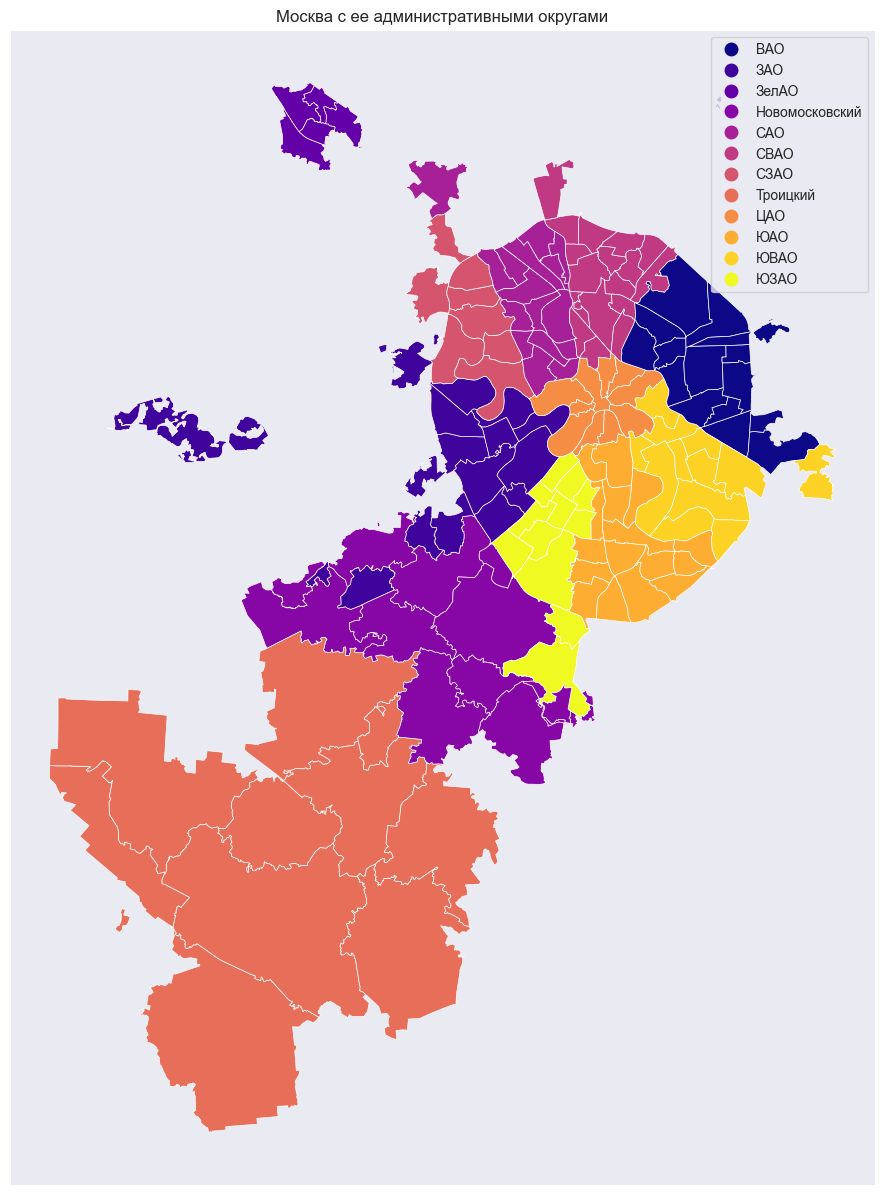

In [15]:
# показать Москву с ее административными округами.
mo_gdf_wm = mo_gdf.to_crs(epsg='3857')
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[15,15])
plt.xticks([])
plt.yticks([])
plt.title("Москва с ее административными округами")
plt.show()

In [16]:
# определяем административный район, в котором находится указанное здание компании, выставившей вакансию, в случае вне Москвы ставим "Не в Москве"
for dataset in datasets:
    dataset["AO"] = dataset[["lat", "lon"]].apply(lambda row: preprocess.find_AO(row, mo_gdf), axis=1)

In [17]:
# оставить только вакансии из Москвы или с удаленной работой в графике.
in_moscow_or_remote = []
for dataset in datasets:
    filtered_dataset = dataset.loc[(dataset["AO"] != "Не в Москве") | (dataset["schedule"] == "Удаленная работа")]
    in_moscow_or_remote.append(filtered_dataset.reset_index(drop=True))


In [18]:
for dataset in in_moscow_or_remote:
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   premium                     5400 non-null   bool   
 1   has_test                    5400 non-null   bool   
 2   response_letter_required    5400 non-null   bool   
 3   salary                      5400 non-null   float64
 4   archived                    5400 non-null   bool   
 5   schedule                    5400 non-null   object 
 6   accept_temporary            5400 non-null   bool   
 7   professional_roles          5400 non-null   object 
 8   accept_incomplete_resumes   5400 non-null   bool   
 9   experience                  5400 non-null   object 
 10  employment                  5400 non-null   object 
 11  is_adv_vacancy              5400 non-null   bool   
 12  employer_trusted            5400 non-null   bool   
 13  employer_type               5398 

Видно, что количество записей уменьшилось, но их все еще достаточно, для анализа и построения модели.

Я имею 9 bool колонок, 7 действительные колонки, 1 целочисленные и 8 категориальные

### EDA и визуал

Посмотрим есть ли выбросы в зарплатах у разных отраслей.

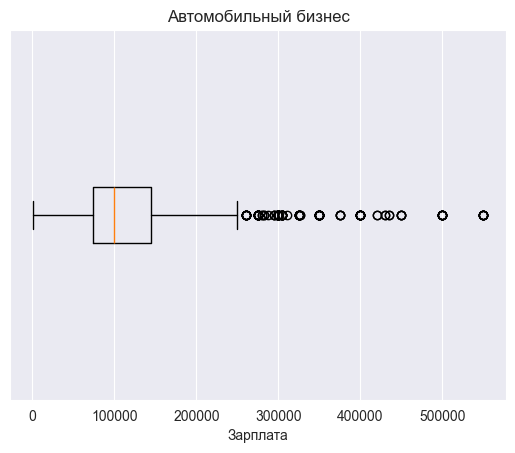

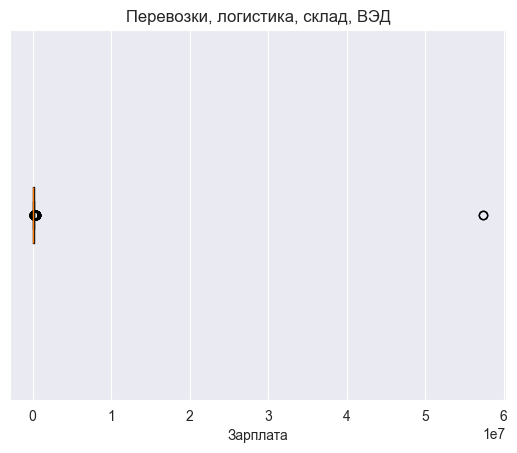

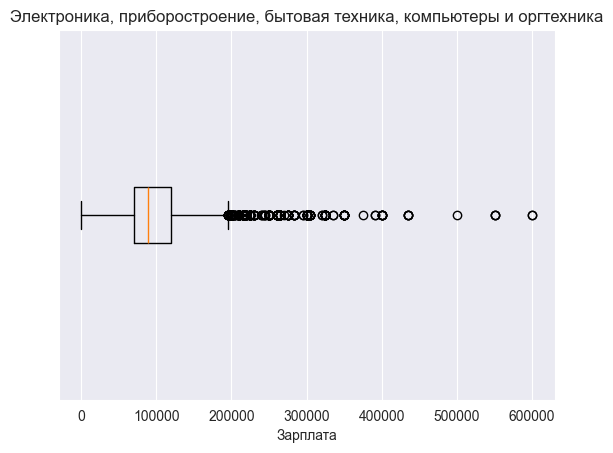

In [19]:
for dataset in in_moscow_or_remote:
    plt.boxplot(dataset["salary"], vert=False)
    plt.title(dataset["industry"][0])
    plt.xlabel("Зарплата")
    plt.yticks([])
    plt.show()

Выбросы есть, от них надо избавиться, чтобы лучше воспринимать действительность. Также, данные с выбросами помешают обучить модель. 

Для понимания основных тенденций надо исключить выбросы, так например один бухгалтер с зарплатой 85 млн может помешать увидеть закономерности в графике зарплат

<img alt="Alt text" height="800" src="images\outlier_example.jpg" width="1000"/>{}

In [20]:
# удаление выбросов, чтобы они не влияли на визуализацию.
dataset_without_outliers = []
for dataset in in_moscow_or_remote:
    # подсчитываем межквартильный размах
    q25, q75 = np.percentile(dataset["salary"], 25), np.percentile(dataset["salary"], 75)
    iqr = q75 - q25
    # подсчитываем нижнюю и верхнюю границы
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # remove outliers
    dataset_without_outliers.append(dataset.loc[(dataset["salary"] <= upper) & (dataset["salary"] >= lower)].reset_index(drop=True))
    

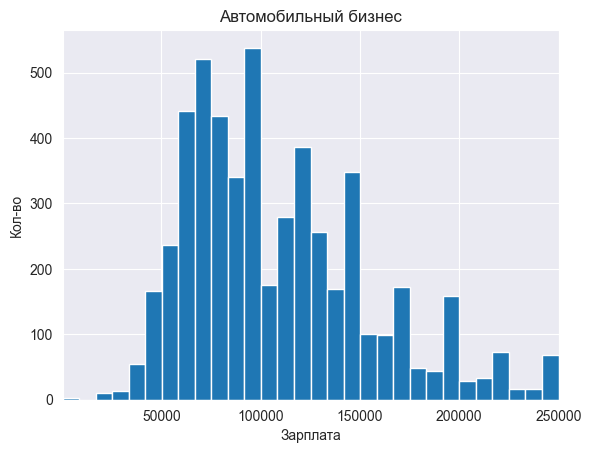

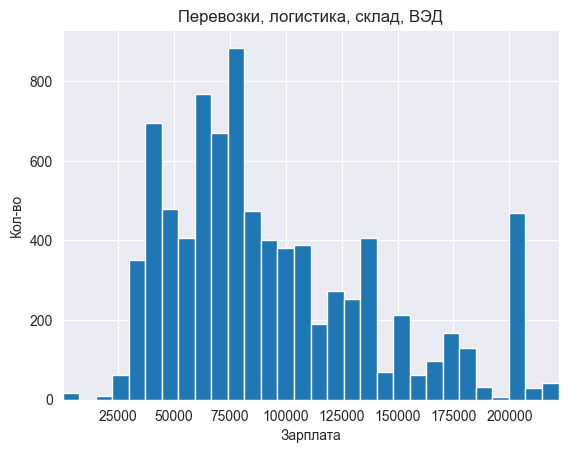

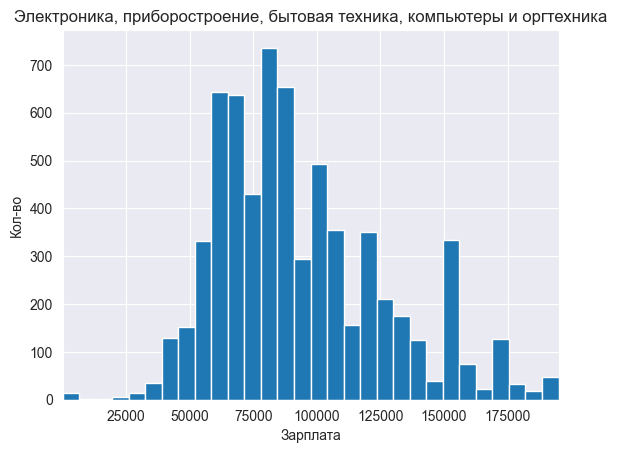

In [21]:
# построить гистограммы зарплат для каждой отрасли.
for dataset in dataset_without_outliers:
    plt.hist(dataset["salary"], 30)
    plt.title(dataset["industry"][0])
    plt.xlim((dataset["salary"].min(), dataset["salary"].max()))
    plt.xlabel("Зарплата")
    plt.ylabel("Кол-во")
    plt.show()

Видно, что графики слегка отличаются. Для более достоверного результата, можно проверить одинаковые ли зарплаты для работников разных отраслей с помощью статистического анализа.

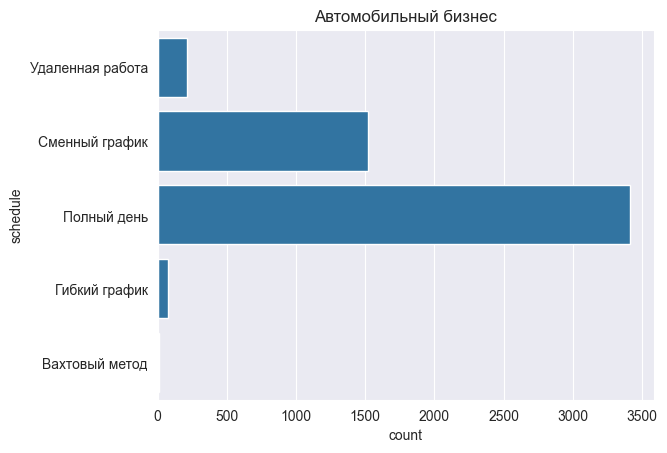

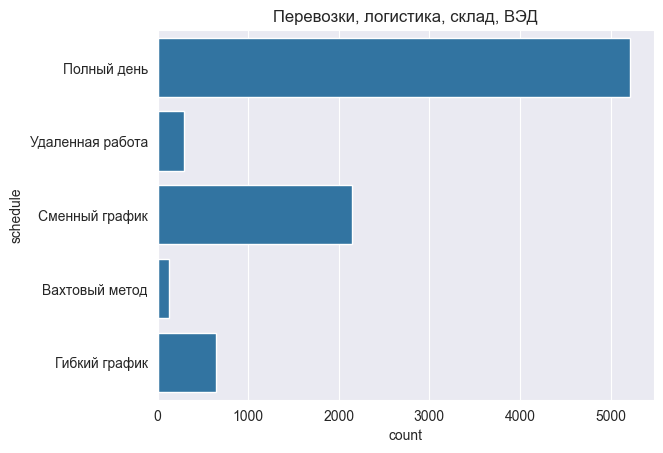

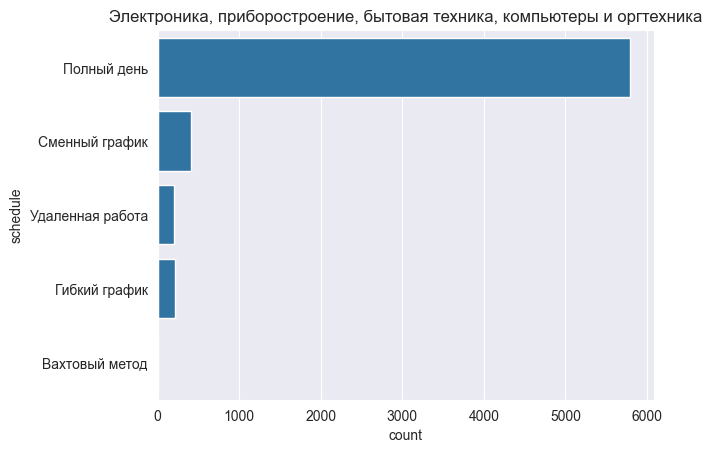

In [22]:
for dataset in dataset_without_outliers:
    sns.countplot(dataset["schedule"])
    plt.title(dataset["industry"][0])
    plt.show()

Видно, что большая часть вакансий нацелена на полный день, хотя остальные виды работы тоже доступны. Надо вынести остальные графики работы в "Другое".

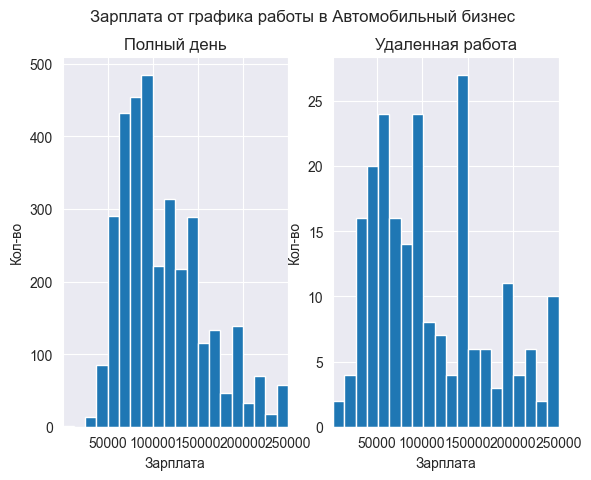

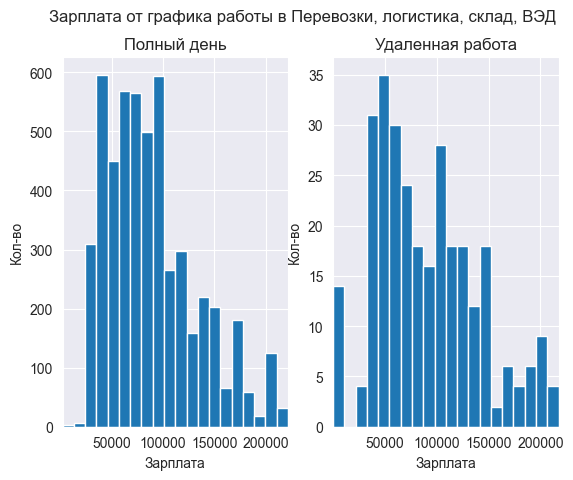

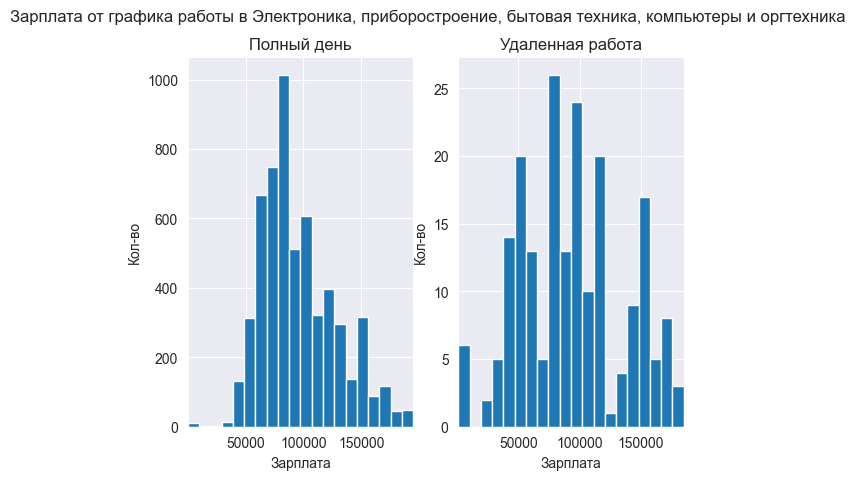

In [23]:
# выводим информацию по вакансиям на удаленку и на полный день
for dataset in dataset_without_outliers:
    in_office = dataset.loc[dataset["schedule"] == "Полный день", "salary"]
    out_office = dataset.loc[dataset["schedule"] == "Удаленная работа", "salary"]
    ax, fig = plt.subplots(ncols=2)
    fig[0].hist(in_office, 20)
    fig[0].set_title("Полный день")
    fig[0].set_xlim((in_office.min(), in_office.max()))
    fig[0].set_xlabel("Зарплата")
    fig[0].set_ylabel("Кол-во")
    fig[1].hist(out_office, 20)
    fig[1].set_title("Удаленная работа")
    fig[1].set_xlim((out_office.min(), out_office.max()))
    fig[1].set_xlabel("Зарплата")
    fig[1].set_ylabel("Кол-во")
    plt.suptitle(f'Зарплата от графика работы в {dataset["industry"][0]}')
    plt.show()

По графикам неочевидно, есть ли отличие между распределением зарплат тех, кто работает полный день в офисе и теми кто не делает так. Различия на графиках могут быть обусловлены особенностями выборки вакансий, поэтому статистический анализ необходим для более точного определения существующих различий или их отсутствия между заработными платами удаленных работников и тех, кто работает в офисе на полный рабочий день.

In [24]:
# какое распределение административных районов имеют вакансии в датасете 0
dataset_without_outliers[0]["AO"].value_counts()

AO
ЮАО               866
ЮВАО              718
САО               651
ЗАО               525
СВАО              511
ВАО               435
ЮЗАО              431
ЦАО               386
Новомосковский    342
СЗАО              202
Не в Москве       162
Троицкий            2
ЗелАО               1
Name: count, dtype: int64

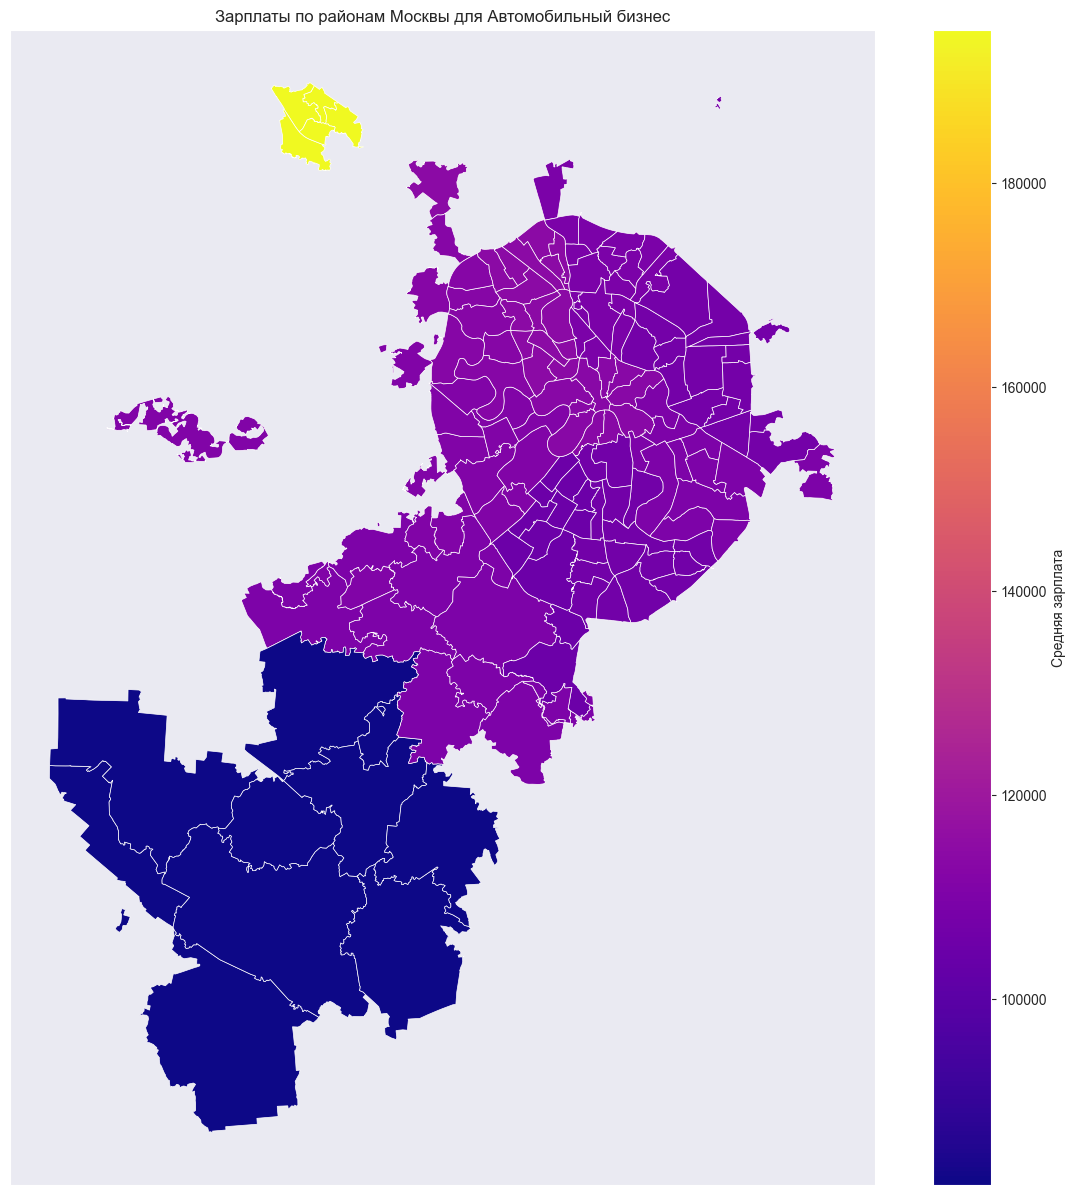

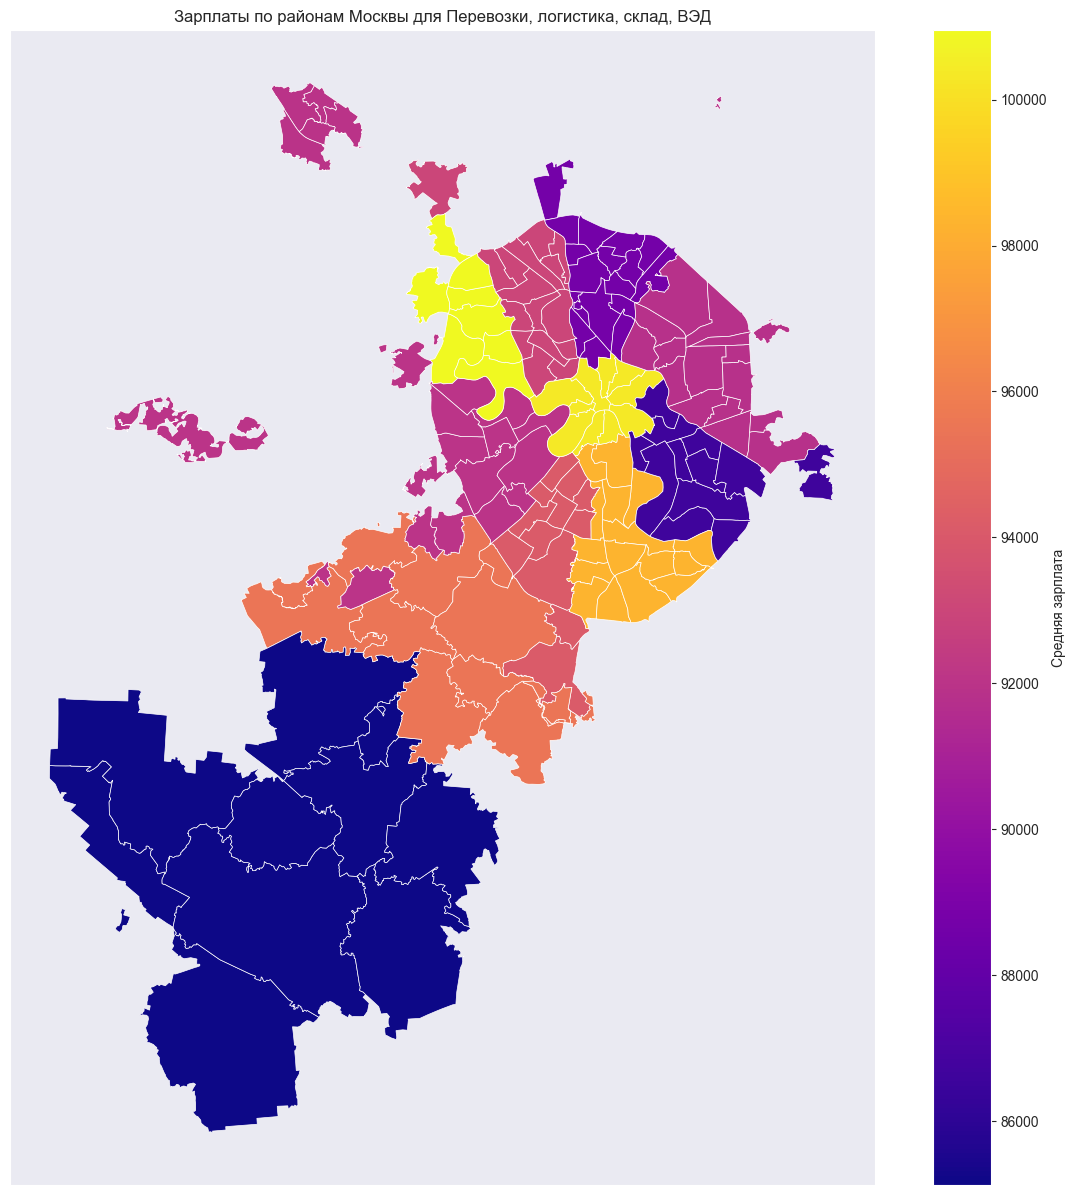

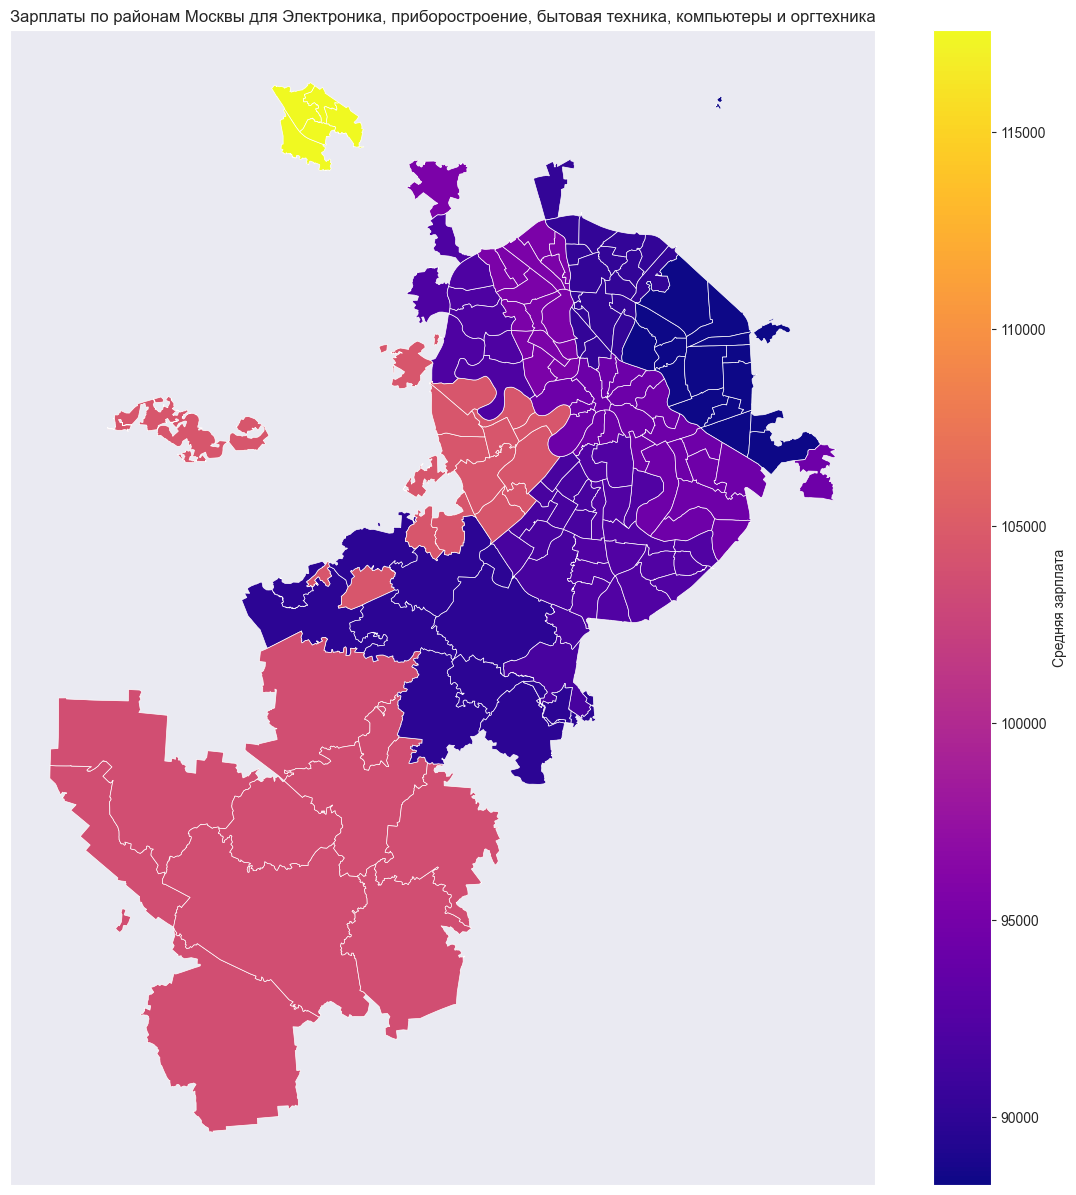

In [25]:
# визуализируем средние указанные зарплаты в вакансиях в административных районах Москвы
visualization.visualize_avg_salary_in_moscow(dataset_without_outliers, mo_gdf)

Зарплата в Москве может отличаться в разных районах и по разным видам работы. Например, в центре города или в IT-сфере она обычно выше, чем в спальных районах или в сфере обслуживания. Поэтому, чтобы понять, сколько можно заработать, нужно учитывать как район, так и отрасль компании. Так мы можем получить более точную картину и сделать правильные выводы о зарплате в Москве.

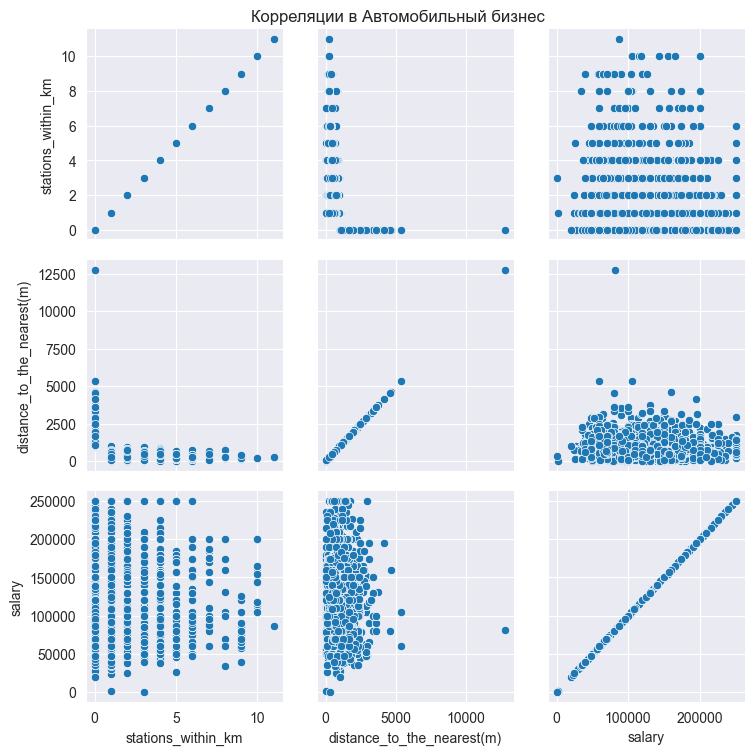

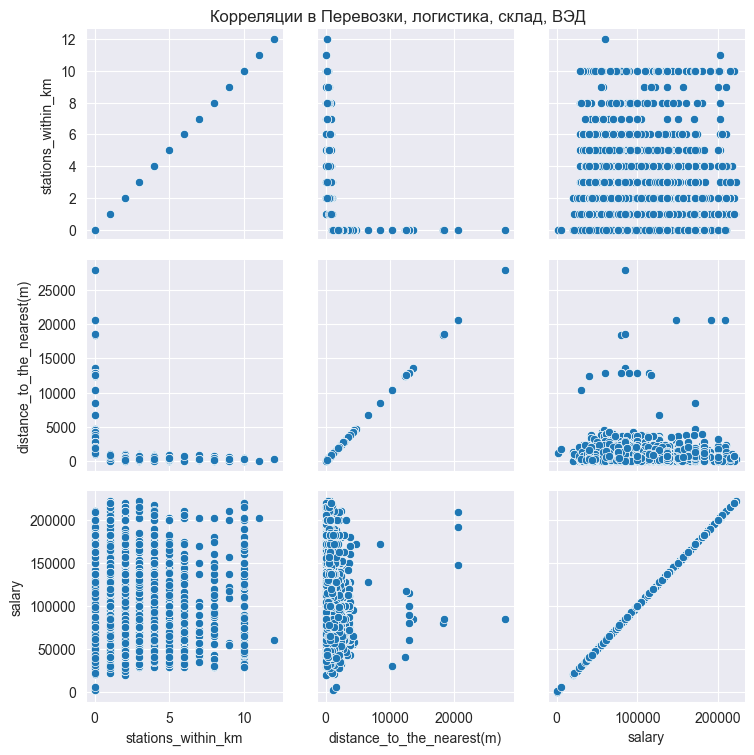

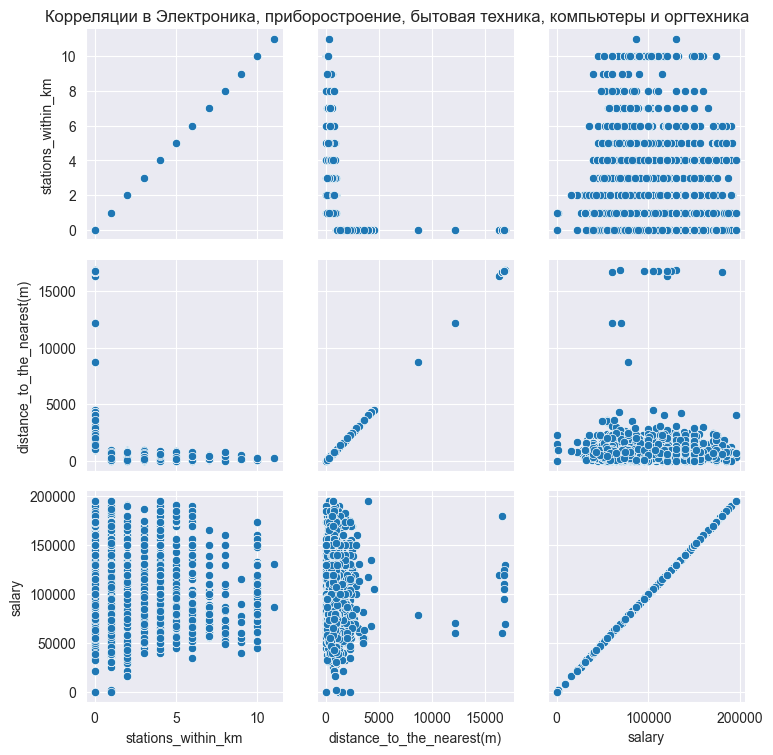

In [26]:
# ищем корреляцию между кол-вом станций, расстоянием до ближайшей станции и зарплатой, используя PairGrid
for dataset in dataset_without_outliers:
    industry = dataset["industry"][0]
    
    pg = sns.PairGrid(dataset[["stations_within_km", "distance_to_the_nearest(m)", "salary"]])
    pg.figure.suptitle(f"Корреляции в {industry}", y=1)
    pg.map(sns.scatterplot)
    

Отсутствует заметная корреляции, мы не наблюдаем определенного паттерна точек на графике, который бы указывал на сильную связь между параметрами. В основном, вакансии имеют значение расстояния от 0 до 2000 метров от ближайшей станции, но это скорее связано с тем, какие вакансии входили в выборку, то есть офисы в большинстве вакансиях расположены рядом с метро. Если в радиусе 1 км нет метро, то ближайшая станция может быть далеко, что кажется логичным.

Теперь можно посмотреть, люди с каким опытом требуются в разные индустрии. И зависит ли зарплата от опыта работы? Скорее всего зависит, но это нужно проверить.

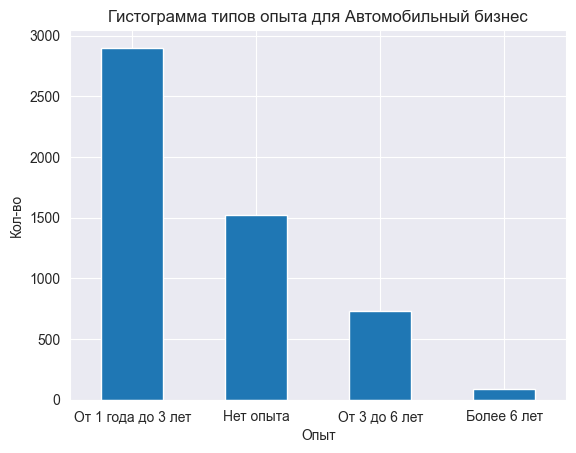

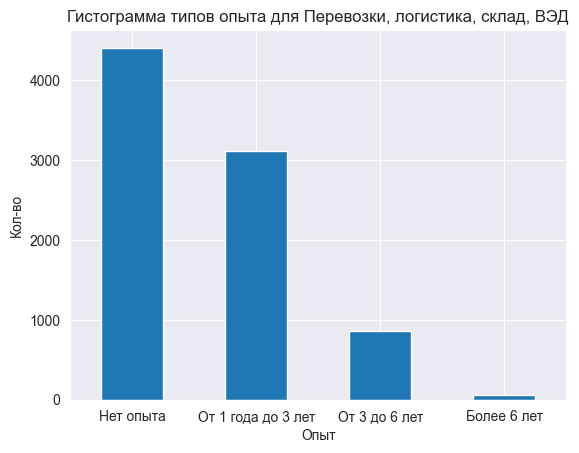

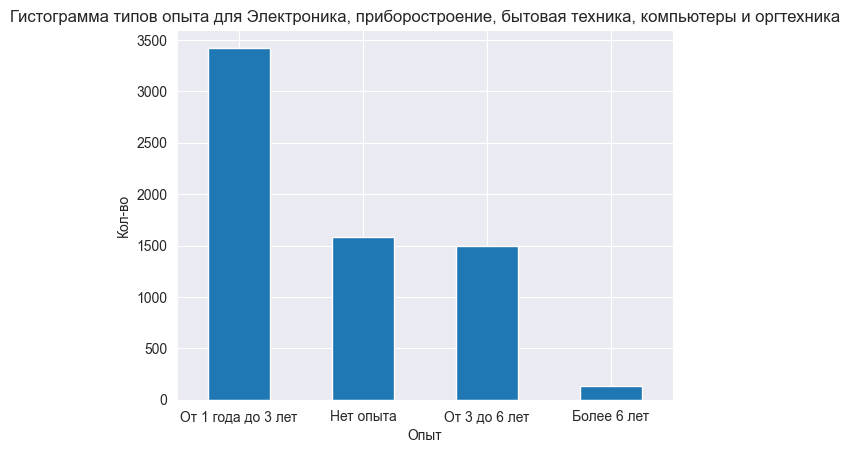

In [27]:
for dataset in dataset_without_outliers:
    exp = {
        "Нет опыта": 0,
        "От 1 года до 3 лет": 0,
        "От 3 до 6 лет": 0,
        "Более 6 лет": 0
    }
    dataset["experience"].value_counts().plot.bar(rot=0)
    plt.title(f'Гистограмма типов опыта для {dataset["industry"][0]}')
    plt.ylabel("Кол-во")
    plt.xlabel("Опыт")
    plt.show()

По распределению столбцов видно, что большинство вакансий расчитаны на опыт от 1 года до 3 лет или нет опыта, но в других индустриях может быть по-другому.

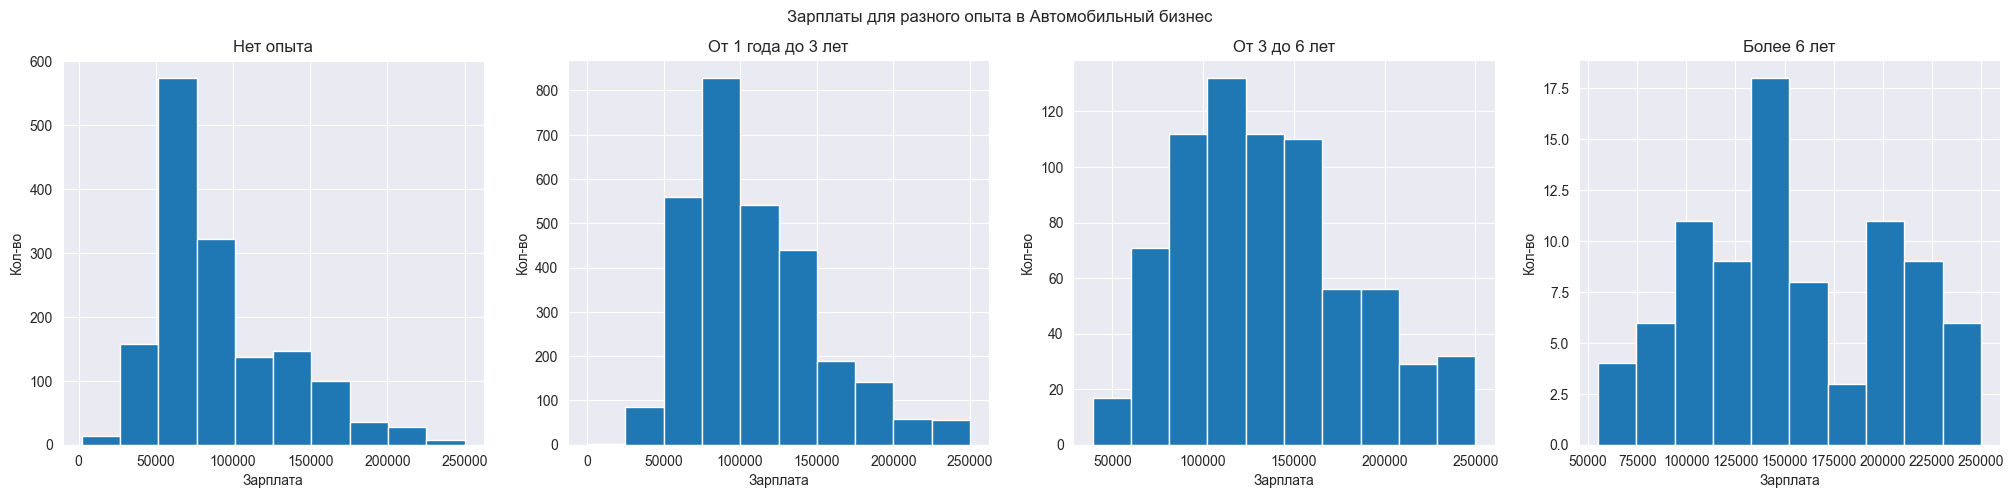

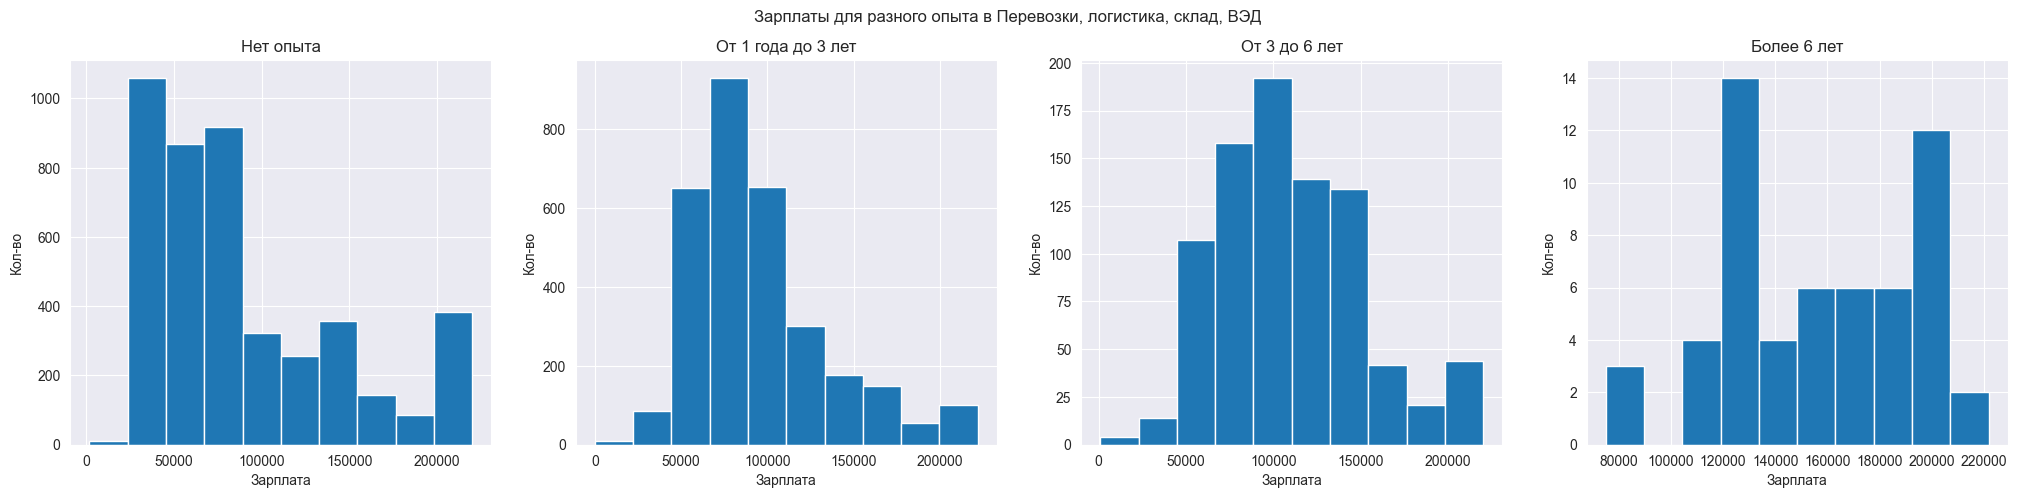

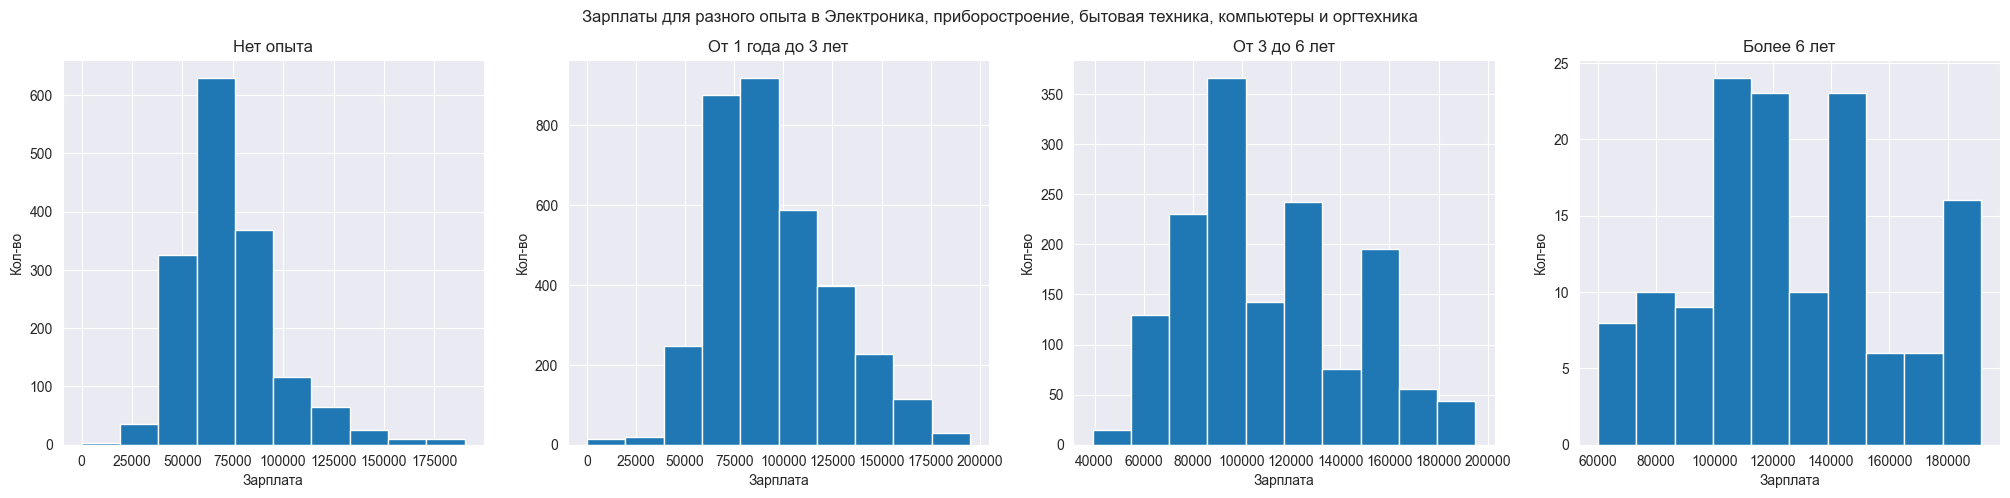

In [28]:
for dataset in dataset_without_outliers:
    _, fig = plt.subplots(ncols=4, figsize=[25,5])
    for i, exp in enumerate(["Нет опыта", "От 1 года до 3 лет", "От 3 до 6 лет", "Более 6 лет"]):
        fig[i].hist(dataset.loc[dataset["experience"]==exp, "salary"], label=exp)
        fig[i].set_title(exp)
        fig[i].set_xlabel('Зарплата')
        fig[i].set_ylabel('Кол-во')
    plt.suptitle(f'Зарплаты для разного опыта в {dataset["industry"][0]}')
    plt.show()

Видно, что есть тенденция к увеличению средней зарплаты с большим опытом. 

Булевские переменные

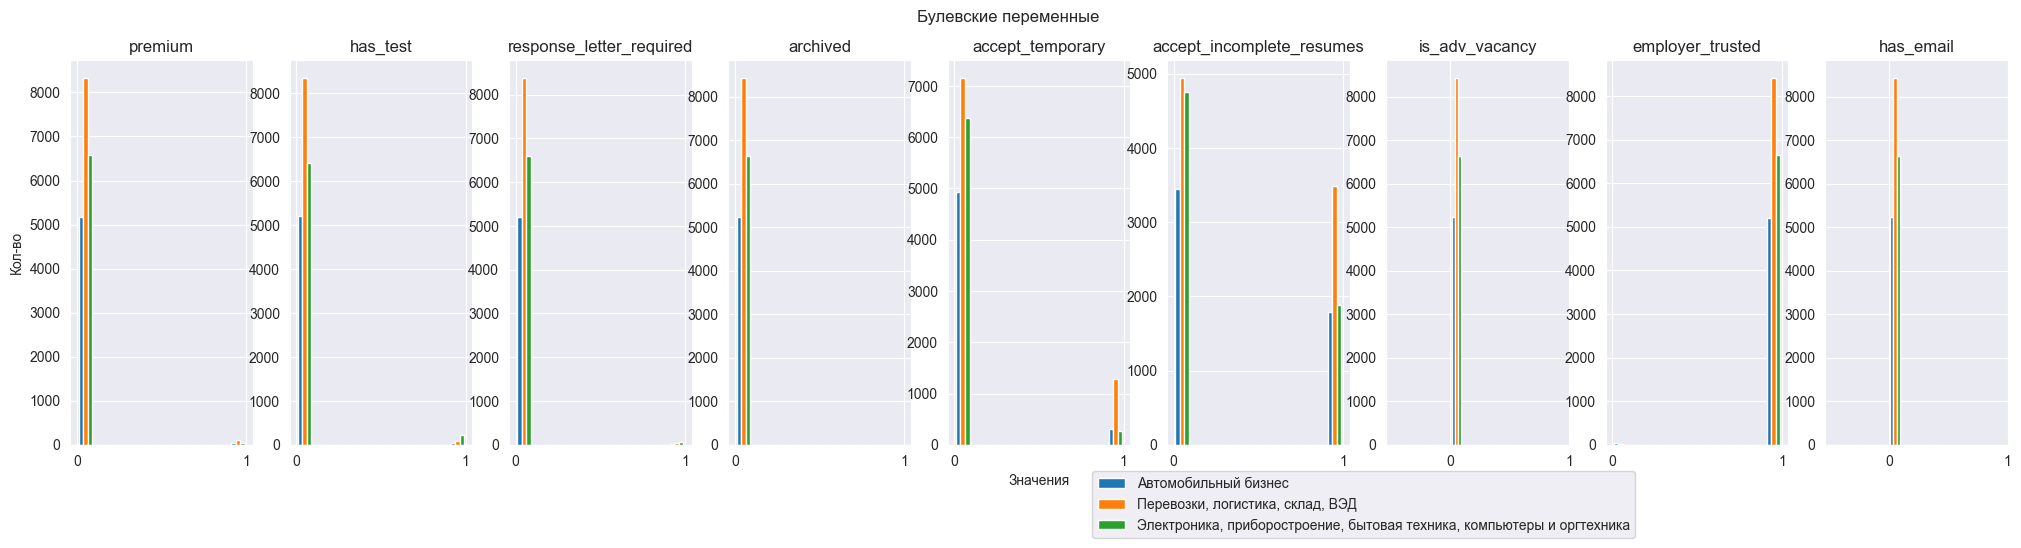

In [29]:
bool_cols = []
for col in dataset_without_outliers[0].columns:
    if dataset_without_outliers[0][col].dtype == bool:
        bool_cols.append(col)
_, fig = plt.subplots(ncols=len(bool_cols), figsize=[25,5])
i_hist = []
names = []
for d in dataset_without_outliers:
    names.append(d['industry'][0])
for i, col in enumerate(bool_cols):
    arr = []
    for dataset in dataset_without_outliers:
        arr.append(dataset[col].apply(lambda x: 1 if x else 0))
    i_hist.append(arr)
plt.suptitle("Булевские переменные")
for i in range(len(bool_cols)):
    fig[i].hist(i_hist[i], label=names)
for i in range(len(bool_cols)):
    fig[i].set_xticks([0, 1])
    fig[i].set_title(bool_cols[i])
    if i == 0:
        fig[i].set_ylabel('Кол-во')
    if i == len(bool_cols)//2:
        fig[i].set_xlabel('Значения')
plt.legend(bbox_to_anchor=(-1, -0.05))
plt.show()

Как видно из графиков большинство булевских переменных не сбалансированы, недостаточно наблюдений, чтобы будущая модель по этим параметрам умела предсказывать нужную зарплату на вакансию. Следует удалить данные колонки во избежание ошибок в прогнозировании. То есть оставить колонки: `accept_temporary`, `accept_incomplete_resumes`. 

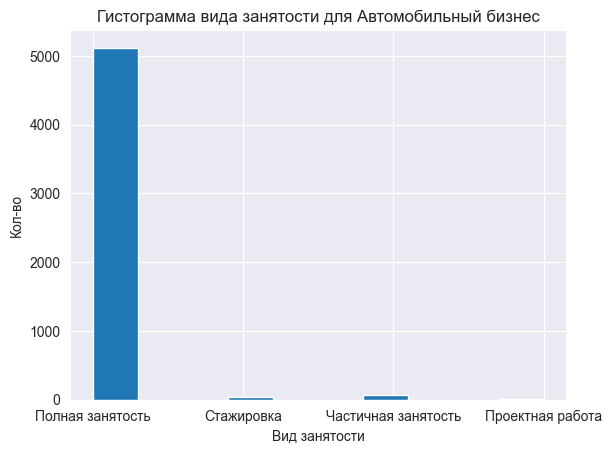

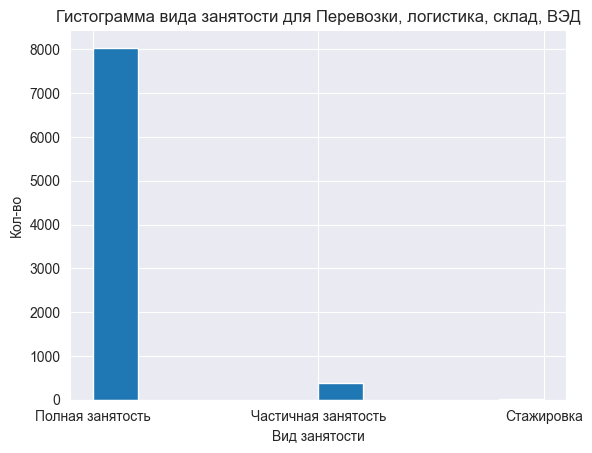

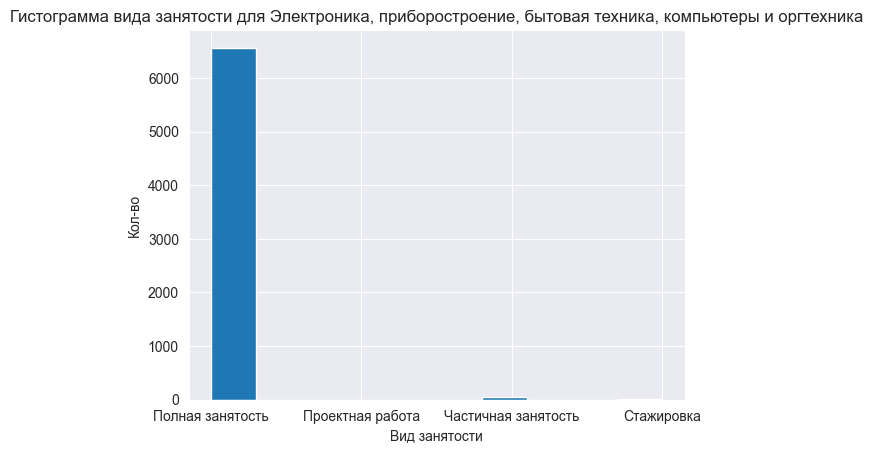

In [30]:
for dataset in dataset_without_outliers:
    plt.hist(dataset["employment"])
    plt.title(f'Гистограмма вида занятости для {dataset["industry"][0]}')
    plt.ylabel("Кол-во")
    plt.xlabel("Вид занятости")
    plt.show()

Как видно большая часть вакансий ориентирована на полную занятость. Вероятно, придется объединить более редко встречающиеся типы занятости в "Другое".

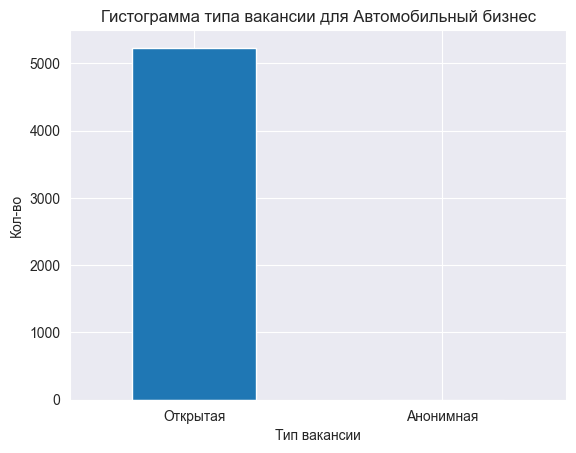

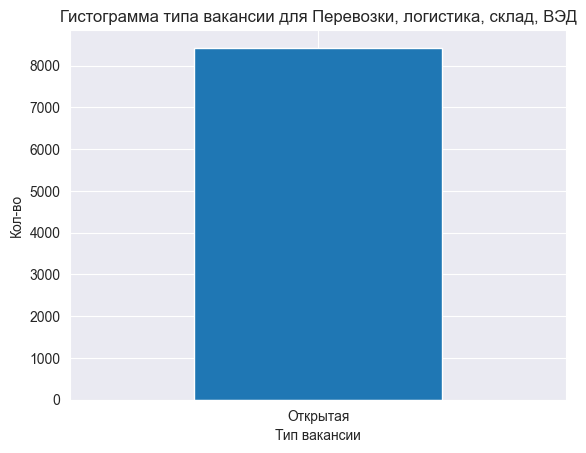

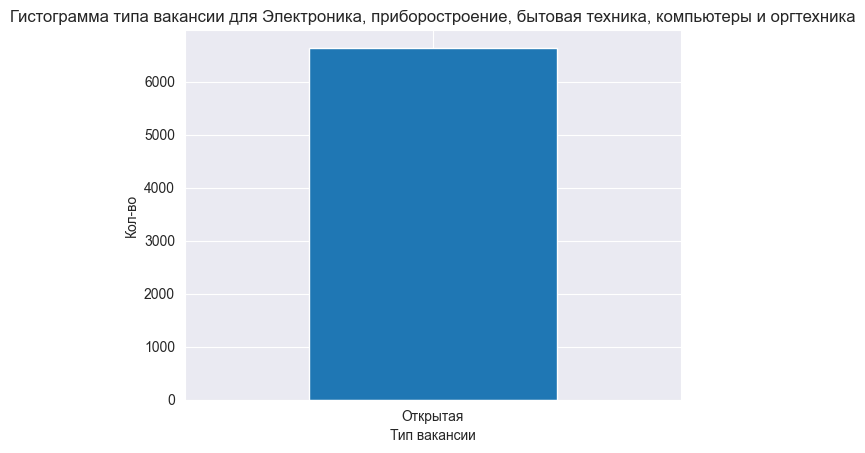

In [31]:
for dataset in dataset_without_outliers:
    dataset["vacancy_type"].value_counts().plot(kind="bar", rot=0)
    plt.title(f'Гистограмма типа вакансии для {dataset["industry"][0]}')
    plt.ylabel("Кол-во")
    plt.xlabel("Тип вакансии")
    plt.show()

Подавляющее большинство вакансий является открытым на момент собирания данных, значит этот столбец можно удалить. 

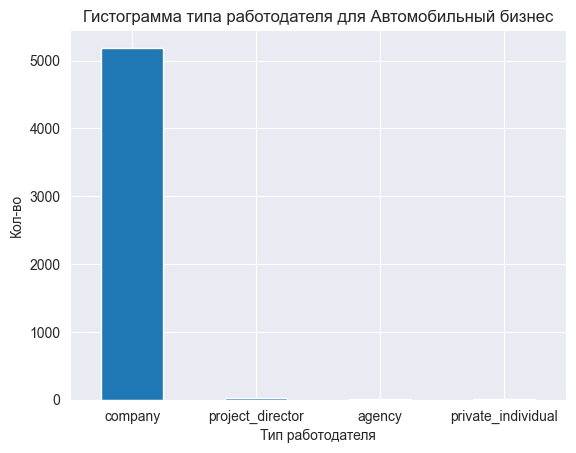

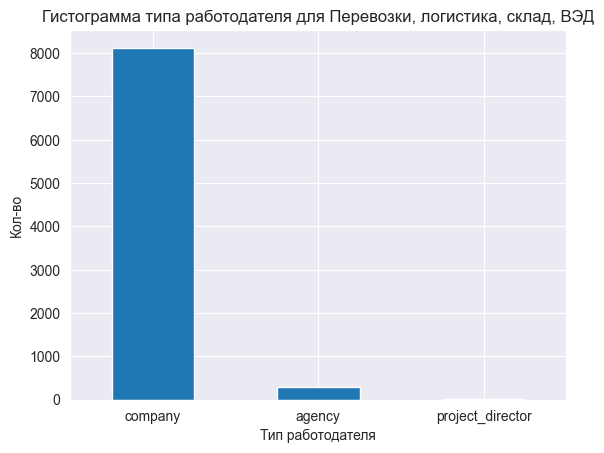

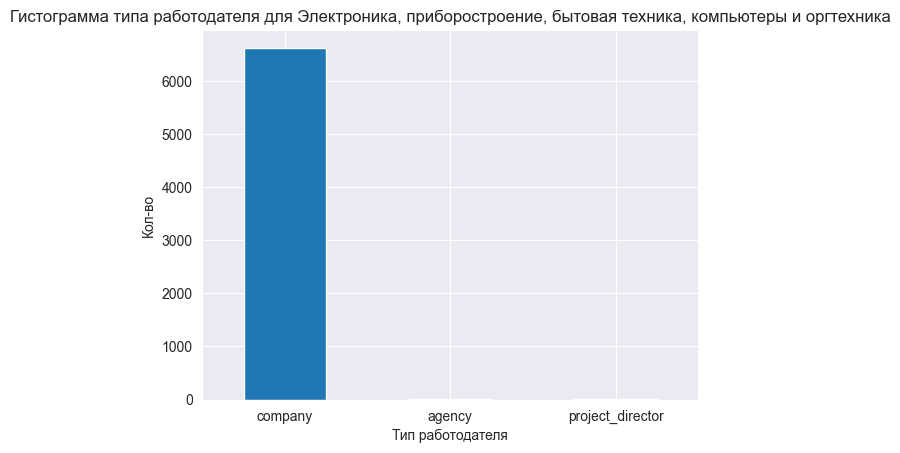

In [32]:
for dataset in dataset_without_outliers:
    dataset["employer_type"].value_counts().plot(kind="bar", rot=0)
    plt.title(f'Гистограмма типа работодателя для {dataset["industry"][0]}')
    plt.ylabel("Кол-во")
    plt.xlabel("Тип работодателя")
    plt.show()

Доминируют вакансии от компании, нежели вакансии от других работодателей, можно объединить в "Другое".

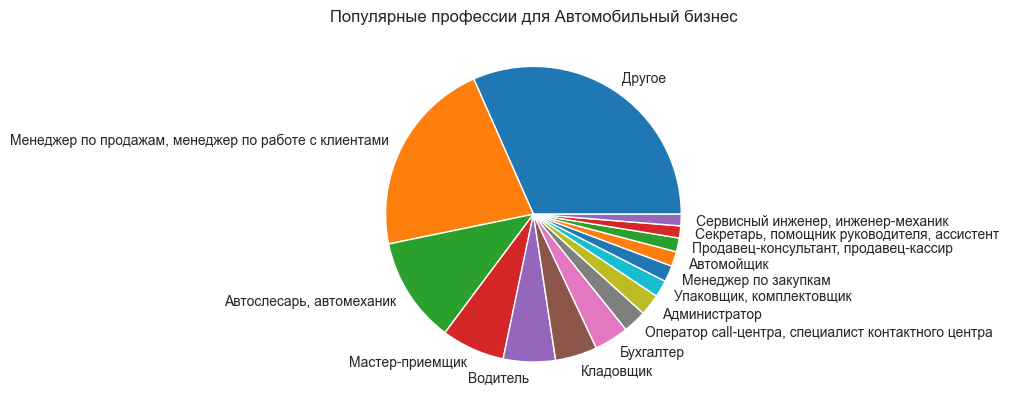

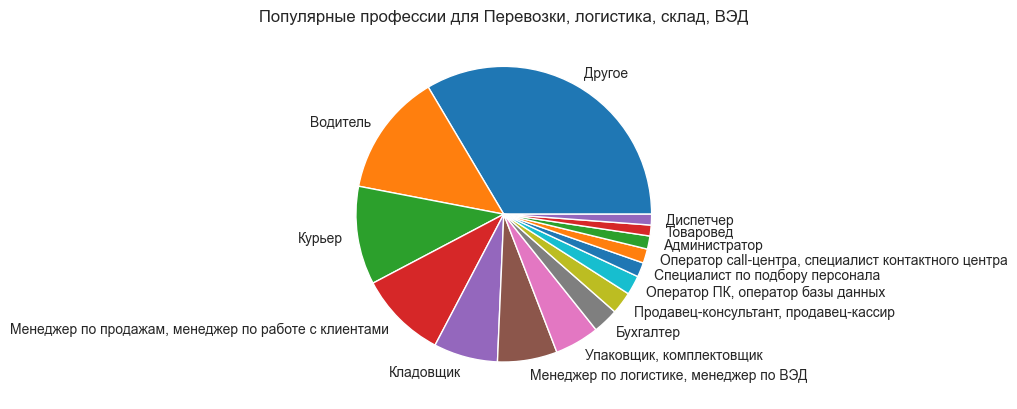

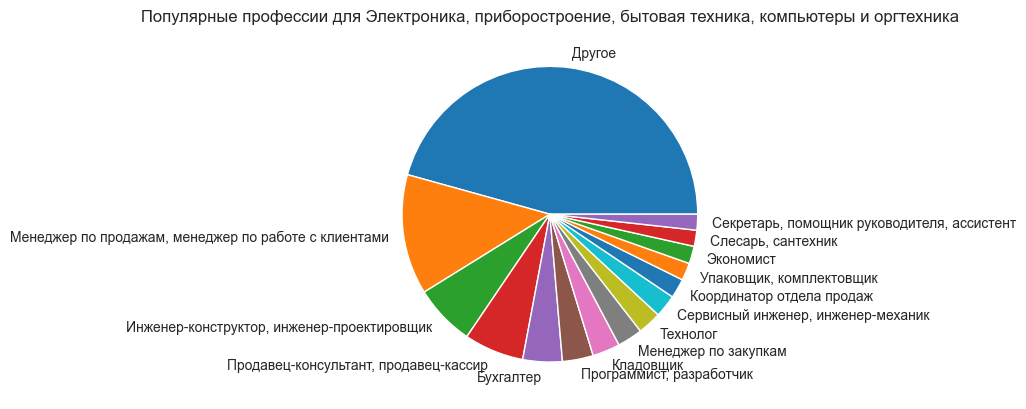

In [33]:
for dataset in dataset_without_outliers:

    # Определение топ-5 категорий
    top_categories = dataset["professional_roles"].value_counts().index[:15]
    
    # Замена категорий, не входящих в топ-5, на "Другое"
    dataset.loc[~dataset["professional_roles"].isin(top_categories), "professional_roles"] = "Другое"
    
    # Подсчет количества категорий
    val_counts = dataset["professional_roles"].value_counts()
    
    # Построение круговой диаграммы
    plt.title(f'Популярные профессии для {dataset["industry"][0]}')
    plt.pie(val_counts.values, labels=val_counts.index.values)
    plt.show()


Получилось выявить топ 15 ролей в каждой индустрии.

### Статистический анализ

На этапе исследовательского анализа данных (EDA) мы выявили важные признаки и взаимосвязи между переменными, которые требуется проверить с помощью статистических методов.

Основные вопросы касались зарплаты: мы интересовались различиями в зарплате между разными группами и подгруппами в нашем датасете. Для проверки этих различий можно использовать тесты, направленные на сравнение средних значений зарплат в различных подмножествах данных, такие как ANOVA или тест Краскела-Уоллиса. 

Кроме того, мы хотели определить, как зарплата зависит от таких факторов, как ближайшая станция метро и количество станций в радиусе километра. Для этого можно применить простую линейную модель и проанализировать коэффициенты независимых признаков. Перед этим стоит изучить зависимость между этими признаками, чтобы понять, как они взаимосвязаны.

In [34]:
import scipy.stats as stats

Проверка равенства медиан средних зарплат в разных отраслях. Для использования ANOVA требуется, чтобы данные подчинялись нормальному распределению.

Воспользуюсь критерием Шапиро-Уилка для определения нормальности с интервалом уверенности в 0.95.

Так как в каждом датасете количество записей больше 5000, p-value для теста Шапиро-Уилка на нормальность может являться неточным. Поэтому, я сделаю контрольную выборку на 5000 элементов в каждом датасете и оценю p-value контрольной выборки. 

In [35]:
# проверка данных на нормальность
alpha = 0.05
for dataset in dataset_without_outliers:
    
    _, p_value = stats.shapiro(dataset["salary"].sample(5000))
    print(dataset["industry"][0])
    if p_value > alpha:
        print("Не отвергаем нулевую гипотезу: данные распределены нормально")
    else:
        print("Отвергаем нулевую гипотезу и принимаем альтернативную: данные распределены не нормально")
    print()

Автомобильный бизнес
Отвергаем нулевую гипотезу и принимаем альтернативную: данные распределены не нормально

Перевозки, логистика, склад, ВЭД
Отвергаем нулевую гипотезу и принимаем альтернативную: данные распределены не нормально

Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
Отвергаем нулевую гипотезу и принимаем альтернативную: данные распределены не нормально



Все данные распределены не нормально, значит нужно воспользоваться тестом Краскела-Уоллиса для определения равности средних значений данных о зарплате в разных отраслях.

- H0: среднее значение зарплат трех отраслей равны между собой
- H1: средние значения неравны 

Интервал уверенности 0.95

In [36]:
# тест Краскела-Уоллиса
alpha = 0.05
salaries = []
for dataset in dataset_without_outliers:
    salaries.append(dataset["salary"].values.reshape(-1, ))
, p_value = stats.kruskal(salaries)
if p_value > alpha:
    print("Не отвергаем нулевую гипотезу: средние равны")
else:
    print("Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
    

Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны


Средние оказались не равны, попробуем понять, в какой отрасли больше средние зарплаты в вакансиях.
Для этого нужно, точно убедится что средние любой пары отраслей не равны. Так как мы имеем всего 3 отрасли то надо будет провести 3 подобных теста Краскела-Уоллиса.

In [37]:
# тест Краскела-Уоллиса для каждой пары индустрий
alpha = 0.05
for i in range(len(dataset_without_outliers) - 1):
    for j in range(i+1, len(dataset_without_outliers)):
        _, p_value = stats.kruskal(dataset_without_outliers[i]["salary"].values.reshape(-1, ), dataset_without_outliers[j]["salary"].values.reshape(-1, ))
        first_ind = dataset_without_outliers[i]["industry"][0]
        second_ind = dataset_without_outliers[j]["industry"][0]
        print(f'{first_ind} и {second_ind}')
        if p_value > alpha:
            print("Не отвергаем нулевую гипотезу: средние равны")
        else:
            print("Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
        print()

Автомобильный бизнес и Перевозки, логистика, склад, ВЭД
Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны

Автомобильный бизнес и Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны

Перевозки, логистика, склад, ВЭД и Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны



В итоге в каждой отрасли своя средняя зарплата, теперь можно проранжировать и выяснить у кого самая высокая средняя зарплата среди 3 отраслей.

In [38]:
for dataset in dataset_without_outliers:
    print(dataset["industry"][0])
    mean = dataset["salary"].mean()
    print(f"Средняя зарплата: {mean}")
    print()

Автомобильный бизнес
Средняя зарплата: 109773.86022075688

Перевозки, логистика, склад, ВЭД
Средняя зарплата: 93766.87367509196

Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
Средняя зарплата: 93312.10391657881



Видно, что больше всех зарплата указана у Автомобильного бизнеса.

Второй вопрос нацелен на различие зарплат между разными типами работы: полный день, удаленная работа, вахтовый метод и другие. Также применим критерий Краскела-Уоллиса.

In [39]:
dataset_without_outliers[0]["schedule"].unique()

array(['Удаленная работа', 'Сменный график', 'Полный день',
       'Гибкий график', 'Вахтовый метод'], dtype=object)

Такие типы графиков работы есть в датасетах. 

- H0: средние значение зарплат двух графиков равны
- H1: средние значения неравны 

Интервал уверенности 0.95

In [40]:
for dataset in dataset_without_outliers:
    industry_name = dataset["industry"][0]
    print(industry_name)
    # делим на график работы по типам
    remote_salary = dataset.loc[dataset["schedule"] == "Удаленная работа", "salary"].values.reshape(-1,)
    full_day_salary = dataset.loc[dataset["schedule"] == "Полный день", "salary"].values.reshape(-1,)
    flexible_salary = dataset.loc[dataset["schedule"] == "Гибкий график", "salary"].values.reshape(-1,)
    shift_salary = dataset.loc[dataset["schedule"] == "Сменный график", "salary"].values.reshape(-1,)
    rotational_salary = dataset.loc[dataset["schedule"] == "Вахтовый метод", "salary"].values.reshape(-1,)
    alpha = 0.05
    schedule_types = [full_day_salary, flexible_salary, shift_salary, rotational_salary, remote_salary]
    # проверяем средние значения сразу у 5 групп
    _, p_value = stats.kruskal(full_day_salary, flexible_salary, shift_salary, rotational_salary, remote_salary)
    if p_value > alpha:
        print("Не отвергаем нулевую гипотезу: средние равны")
    else:
        print("Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
    # проверяем средние значения каждая группа с каждой другой
    schedule_names = ["Полный день", "Гибкий график", "Сменный график", "Вахтовый метод", "Удаленная работа"]
    for i in range(len(schedule_types) - 1):
        for j in range(i + 1, len(schedule_types)):
            print("\t", schedule_names[i], " и ", schedule_names[j])
            _, p_value = stats.kruskal(schedule_types[i], schedule_types[j])
            if p_value > alpha:
                print("\t Не отвергаем нулевую гипотезу: средние равны")
            else:
                print("\t Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
            print()
    print()


Автомобильный бизнес
Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Полный день  и  Гибкий график
	 Не отвергаем нулевую гипотезу: средние равны

	 Полный день  и  Сменный график
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны

	 Полный день  и  Вахтовый метод
	 Не отвергаем нулевую гипотезу: средние равны

	 Полный день  и  Удаленная работа
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны

	 Гибкий график  и  Сменный график
	 Не отвергаем нулевую гипотезу: средние равны

	 Гибкий график  и  Вахтовый метод
	 Не отвергаем нулевую гипотезу: средние равны

	 Гибкий график  и  Удаленная работа
	 Не отвергаем нулевую гипотезу: средние равны

	 Сменный график  и  Вахтовый метод
	 Не отвергаем нулевую гипотезу: средние равны

	 Сменный график  и  Удаленная работа
	 Не отвергаем нулевую гипотезу: средние равны

	 Вахтовый метод  и  Удаленная работа
	 Не отвергаем нулевую гипотезу: средние равны


Перевозки, логистика

Видно, что график работы влияет на среднюю зарплату, указанную в вакансии. Некоторые графики работы имеют одинаковые средние, однако такие пары разные для разных отраслей.

Следующее, влияют ли кол-во станций в радиусе километра и расстояние до ближайшей станции на предлагаемую зарплату.
Во-первых, нужно понять независимы ли эти две переменные с помощью корреляционного анализа Пирсона.  

In [41]:
alpha = 0.05  # Уровень значимости
for dataset in dataset_without_outliers:
    print(dataset["industry"][0])
    filtered_dataset = dataset.dropna(subset=["distance_to_the_nearest(m)", "stations_within_km"])

    # подсчитать коэффициент Пирсона и p-value
    correlation, p_value = stats.pearsonr(filtered_dataset["distance_to_the_nearest(m)"], filtered_dataset["stations_within_km"])
    print("Корреляция:", correlation)
    print("p-value:", p_value)
    if p_value > alpha:
        print("Не отвергаем нулевую гипотезу: нет статистически значимой корреляции")
    else:
        print("Отвергаем нулевую гипотезу: есть статистически значимая корреляция")
    print()

Автомобильный бизнес
Корреляция: -0.49815060339746137
p-value: 1.23194725e-316
Отвергаем нулевую гипотезу: есть статистически значимая корреляция

Перевозки, логистика, склад, ВЭД
Корреляция: -0.3195699505971442
p-value: 8.975256507900369e-194
Отвергаем нулевую гипотезу: есть статистически значимая корреляция

Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
Корреляция: -0.29921963615864494
p-value: 1.6219193647830189e-134
Отвергаем нулевую гипотезу: есть статистически значимая корреляция



Количество метро и расстояние до ближайшей станции имеют статистическую корреляцию, и кореляция отрицательна, то есть чем больше станций в радиусе километра, тем меньше до ближайшей станции. 

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
for dataset in dataset_without_outliers:
    print(dataset["industry"][0])
    sub_dataset = dataset[["distance_to_the_nearest(m)", "stations_within_km", "salary"]]
    # отбрасываем пустые значение
    filtered_sub_dataset = sub_dataset.dropna(subset=["distance_to_the_nearest(m)", "stations_within_km", "salary"])
    standardized_dataset = StandardScaler().fit_transform(filtered_sub_dataset)
    # учим линейную модель
    linear_regression = LinearRegression()
    linear_regression.fit(standardized_dataset[:,:-1], standardized_dataset[:,-1])
    print(pd.DataFrame(list(zip(linear_regression.coef_, sub_dataset.columns[:-1]))))
    

Автомобильный бизнес
          0                           1
0  0.025588  distance_to_the_nearest(m)
1  0.019671          stations_within_km
Перевозки, логистика, склад, ВЭД
          0                           1
0 -0.023133  distance_to_the_nearest(m)
1  0.042276          stations_within_km
Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
          0                           1
0  0.040118  distance_to_the_nearest(m)
1  0.062400          stations_within_km


У количества станций возле адреса компании всегда положительный коэффициент, то есть зарплата увеличивается с увеличением кол-ва станций метро рядом. Расстояние до ближайшей станции же непостоянно, и коэффициент меняется в зависимости от отрасли компании и специфичных условий этой отрасли.

Влияет ли вид занятости на среднюю зарплату, для этого можно разбить на две категории из-за малого кол-ва подмножеств, не являющимися полной занятостью.
- H0: средние значение равны между собой
- H1: средние значения неравны 

Интервал уверенности 0.95

In [43]:
alpha = 0.05
for dataset in dataset_without_outliers:
    print(dataset["industry"][0])
    full_work = dataset.loc[dataset["employment"] == "Полная занятость", "salary"].values
    not_full_work = dataset.loc[dataset["employment"] != "Полная занятость", "salary"].values
    _, p_value = stats.kruskal(full_work, not_full_work)
    if p_value > alpha:
        print("\t Не отвергаем нулевую гипотезу: средние равны")
    else:
        print("\t Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
    print(f"Среднее у полной занятости: {full_work.mean()}")
    print(f"Среднее у не полной занятости: {not_full_work.mean()}")
    print()
        
    

Автомобильный бизнес
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
Среднее у полной занятости: 110300.54448515044
Среднее у не полной занятости: 86128.50877192983

Перевозки, логистика, склад, ВЭД
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
Среднее у полной занятости: 92227.48419310688
Среднее у не полной занятости: 125490.13846153846

Электроника, приборостроение, бытовая техника, компьютеры и оргтехника
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
Среднее у полной занятости: 93555.30099207557
Среднее у не полной занятости: 73111.35443037975



Видно, что у вакансий с полной занятостью зарплата выше, чем у других видов занятости. Это логично, ведь при полной занятости работник работает больше, чем при частичной занятости, и квалификацией является выше, чем стажер.

Проверим влияние опыта на среднюю зарплату в вакансии, сравним каждое количество опыта с другими.
- H0: среднее значения равны между собой
- H1: средние значения неравны 

Интервал уверенности 0.95

In [44]:
alpha = 0.05
for dataset in dataset_without_outliers:
    industry_name = dataset["industry"][0]
    print(industry_name)
    # делим на категории опыта
    no_exp_salary = dataset.loc[dataset["experience"] == "Нет опыта", "salary"].values.reshape(-1,)
    one_three_salary = dataset.loc[dataset["experience"] == "От 1 года до 3 лет", "salary"].values.reshape(-1,)
    three_six_salary = dataset.loc[dataset["experience"] == "От 3 до 6 лет", "salary"].values.reshape(-1,)
    more_six_salary = dataset.loc[dataset["experience"] == "Более 6 лет", "salary"].values.reshape(-1,)
    exp_types = [no_exp_salary, one_three_salary, three_six_salary, more_six_salary]
    # проверяем равенство средних у сразу 4 групп
    _, p_value = stats.kruskal(no_exp_salary, one_three_salary, three_six_salary, more_six_salary)
    if p_value > alpha:
        print("Не отвергаем нулевую гипотезу: средние равны")
    else:
        print("Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
    # сравниваем каждый вид опыта с каждым другим
    exp_names = ["Нет опыта", "От 1 года до 3 лет", "От 3 до 6 лет", "Более 6 лет"]
    for i in range(len(exp_types) - 1):
        for j in range(i + 1, len(exp_types)):
            print("\t", exp_names[i], " и ", exp_names[j])
            _, p_value = stats.kruskal(exp_types[i], exp_types[j])
            if p_value > alpha:
                print("\t Не отвергаем нулевую гипотезу: средние равны")
            else:
                print("\t Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны")
            print(f"\t Среднее {exp_names[i]}: {exp_types[i].mean()}")
            print(f"\t Среднее {exp_names[j]}: {exp_types[j].mean()}")
            print()
    print()


Автомобильный бизнес
Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Нет опыта  и  От 1 года до 3 лет
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Среднее Нет опыта: 91470.24247039475
	 Среднее От 1 года до 3 лет: 111562.25642068966

	 Нет опыта  и  От 3 до 6 лет
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Среднее Нет опыта: 91470.24247039475
	 Среднее От 3 до 6 лет: 135610.07496561212

	 Нет опыта  и  Более 6 лет
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Среднее Нет опыта: 91470.24247039475
	 Среднее Более 6 лет: 155094.11764705883

	 От 1 года до 3 лет  и  От 3 до 6 лет
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Среднее От 1 года до 3 лет: 111562.25642068966
	 Среднее От 3 до 6 лет: 135610.07496561212

	 От 1 года до 3 лет  и  Более 6 лет
	 Отвергаем нулевую гипотезу и принимаем альтернативную: средние не равны
	 Среднее От 1 года

Видно, что предлагаемая заплата растет с необходимым опытом. Чем больше опыт, тем больше зарплата.

### Построение модели


In [45]:
# импортим библиотеки для модели
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, RobustScaler
from sklearn.naive_bayes import CategoricalNB

На этапе EDA было определено, что не все булеские признаки несбалансированны и их надо убрать, оставив `accept_incomplete_resumes`, `accept_temporary`. Также признак занятость, следует разбить на 2 подгруппы: полная занятость и не полная занятость. Ещё, надо разделить тип работодателя: компания и не компания, из-за малого кол-ва работодателей-не-компаний. Все вакансии являются открытыми на момент собирания данных, значит столбец типа вакансии можно удалить.


In [46]:
industry_names = [dataset['industry'][0] for dataset in dataset_without_outliers]

In [47]:
dataset_for_model = pd.concat(dataset_without_outliers, axis=0, ignore_index=True)
bool_cols = [col for col in dataset_for_model.columns if dataset_for_model[col].dtype == bool and col not in ['accept_incomplete_resumes', 'accept_temporary']]
dataset_for_model.drop(bool_cols, axis=1, inplace=True)
dataset_for_model.drop(["vacancy_type"], axis=1, inplace=True)
dataset_for_model.loc[dataset_for_model["employment"] != "Полная занятость", "employment"] = "Не полная занятость"
dataset_for_model.loc[dataset_for_model["employer_type"] != "company", "employer_type"] = "not a company"

In [48]:
# разделяем колонки по типу данных
int_float_cols = dataset_for_model.select_dtypes(include=['int64', 'float64']).columns
bool_object_cols = dataset_for_model.select_dtypes(include=['bool', 'object']).columns
# для каждого вида колонок создаем pipeline
int_float_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))  # медиана для целочисленных и действительных колонок
])

bool_object_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  # мода для категориальных и булевских
])

# комбинируем pipiline-ы, используя ColumnTransformer
preprocessor = ColumnTransformer([
    ('int_float', int_float_pipe, int_float_cols),
    ('bool_object', bool_object_pipe, bool_object_cols)
])

transformed_data = preprocessor.fit_transform(dataset_for_model)

# вручную создать DataFrame с преобразованными данными, названиями столбцов и типами данных
transformed_df = pd.DataFrame(transformed_data, columns=np.concatenate([int_float_cols, bool_object_cols]))
transformed_df[int_float_cols] = transformed_df[int_float_cols].astype(dataset_for_model[int_float_cols].dtypes)
transformed_df[bool_object_cols] = transformed_df[bool_object_cols].astype(dataset_for_model[bool_object_cols].dtypes)

In [49]:
# делим на признаки и таргеты 
X, y = transformed_df.drop(columns=["salary"]), transformed_df["salary"]

In [50]:
# кодируем категориальные признаки OneHotEncoder
cat_cols = [col for col in X.columns if X[col].dtype == object]
ohe = OneHotEncoder(sparse_output=False).fit(dataset_for_model[cat_cols])
encoded = pd.DataFrame(ohe.transform(X[cat_cols]))
encoded.columns = ohe.get_feature_names_out(cat_cols)
non_cat_cols = [col for col in X.columns if X[col].dtype in ['float64', 'int64']]
final_dataset = pd.concat([encoded, X[non_cat_cols]], axis=1)

In [51]:
# так выглядит final_dataset признаки после кодирования
final_dataset.head()

,schedule_Вахтовый метод,schedule_Гибкий график,schedule_Полный день,schedule_Сменный график,schedule_Удаленная работа,professional_roles_Автомойщик,"professional_roles_Автослесарь, автомеханик",professional_roles_Администратор,professional_roles_Бухгалтер,professional_roles_Водитель,...,AO_ЮАО,AO_ЮВАО,AO_ЮЗАО,industries_count,vacancies_count,phones_count,lat,lon,stations_within_km,distance_to_the_nearest(m)
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0,55.741637,37.606334,1.0,681.122168
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,5.0,30.0,0,55.794922,37.651583,2.0,808.908176
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,5.0,16.0,0,55.709825,37.937480,0.0,1037.894289
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,3.0,12.0,0,55.614922,37.628451,0.0,1479.020093
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,5.0,0,55.791263,37.504600,3.0,388.071269


In [52]:
# RobustScaler масштабирует данные, уменьшая влияние выбросов и обеспечивая стабильные предсказания.
final_dataset[non_cat_cols] = RobustScaler().fit_transform(final_dataset[non_cat_cols])

In [53]:
# делим на тренировочную и тестовую выборку
x_train, x_test, y_train, y_test = train_test_split(final_dataset, y, test_size=0.2, random_state=123)

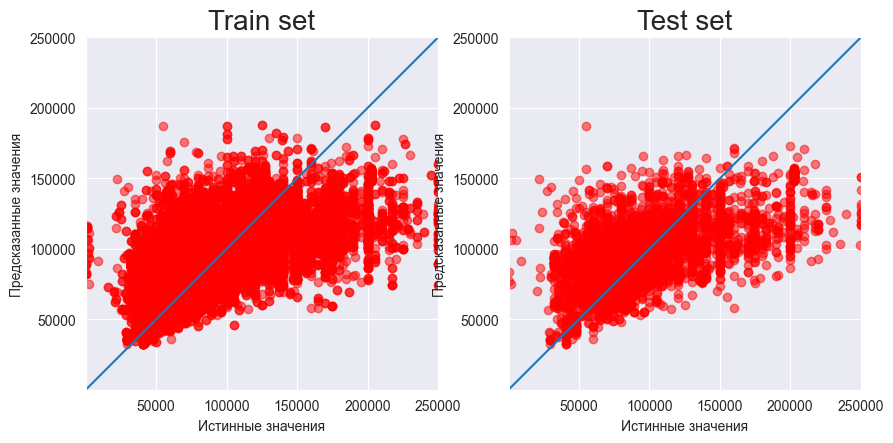

In [54]:
# учим линейную регрессию
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_test = lin_reg.predict(x_test)
y_pred_train = lin_reg.predict(x_train)
visualization.plot_yreal_ypred(y_test, y_train, y_pred_test, y_pred_train)

Как видим простая линейная регрессия справляется плохо, очевидно, что зависимость между признаками и таргетом нелинейна.

Как справится PolynomialRegression?

In [55]:
# Определяем числовые и категориальные признаки
numeric_features = [col for col in X.columns if X[col].dtype in ["int64", "float64"]]
non_numeric_features = [col for col in final_dataset.columns if col not in numeric_features]
# Создаем преобразователи для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=2))  # Применяем полиномиальные признаки только к числовым
])

# Объединяем преобразователи с помощью ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('non_num', 'passthrough', non_numeric_features)
    ])

# Создаем конвейер с преобразованием и моделью
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('linear_model', LinearRegression())])

# Определяем параметры сетки для поиска наилучшей степени полинома
degree_hyper_param = {'preprocessor__num__polynomial_features__degree': range(2, 8)}

# Создаем экземпляр GridSearchCV
search = GridSearchCV(pipeline, degree_hyper_param, scoring='neg_mean_squared_error', cv=3, verbose=2)

# Запускаем поиск по сетке
search.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...preprocessor__num__polynomial_features__degree=2; total time=   0.1s
[CV] END ...preprocessor__num__polynomial_features__degree=2; total time=   0.0s
[CV] END ...preprocessor__num__polynomial_features__degree=2; total time=   0.0s
[CV] END ...preprocessor__num__polynomial_features__degree=3; total time=   0.2s
[CV] END ...preprocessor__num__polynomial_features__degree=3; total time=   0.2s
[CV] END ...preprocessor__num__polynomial_features__degree=3; total time=   0.2s
[CV] END ...preprocessor__num__polynomial_features__degree=4; total time=   0.7s
[CV] END ...preprocessor__num__polynomial_features__degree=4; total time=   4.0s
[CV] END ...preprocessor__num__polynomial_features__degree=4; total time=   1.2s
[CV] END ...preprocessor__num__polynomial_features__degree=5; total time=   2.7s
[CV] END ...preprocessor__num__polynomial_features__degree=5; total time=   2.0s
[CV] END ...preprocessor__num__polynomial_feature

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('polynomial_features',
                                                                                          PolynomialFeatures())]),
                                                                         ['industries_count',
                                                                          'vacancies_count',
                                                                          'phones_count',
                                                                          'lat',
                                                                          'lon',
                                                                          'stations_within_km',
                                                                          'distance_to_the_nearest(m)']),
                                                                        ('non_num',
                                                                         'passthrough',
                                                                         ['schedule_Вахтовый '
                                                                          'метод',
                                                                          'schedule_Гибкий '
                                                                          '...
                                                                          'professional_roles_Сервисный '
                                                                          'инженер, '
                                                                          'инженер-механик',
                                                                          'professional_roles_Слесарь, '
                                                                          'сантехник',
                                                                          'professional_roles_Специалист '
                                                                          'по '
                                                                          'подбору '
                                                                          'персонала',
                                                                          'professional_roles_Технолог',
                                                                          'professional_roles_Товаровед', ...])])),
                                       ('linear_model', LinearRegression())]),
             param_grid={'preprocessor__num__polynomial_features__degree': range(2, 8)},
             scoring='neg_mean_squared_error', verbose=2)

{'preprocessor__num__polynomial_features__degree': 2}


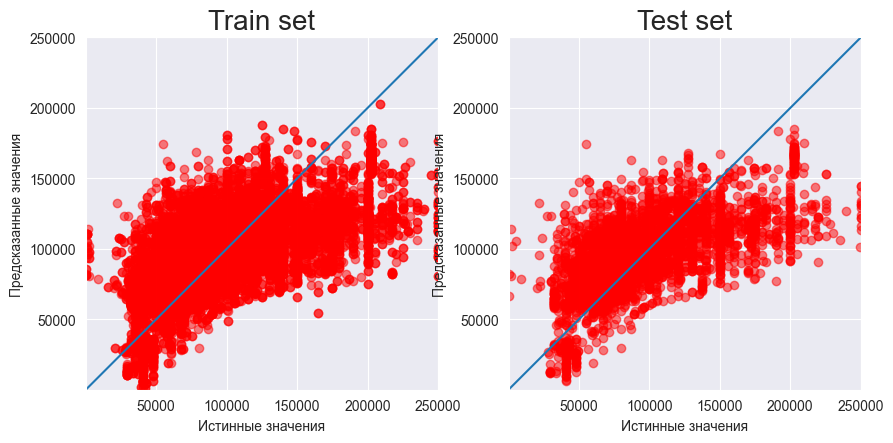

In [56]:
# лучшие параметры для PolynomialRegression найденные по сетке
print(search.best_params_)
# результаты модели
y_test_pred = search.predict(x_test)
y_train_pred = search.predict(x_train)
visualization.plot_yreal_ypred(y_test, y_train, y_test_pred, y_train_pred)

PolynomialRegression справляется также плохо. Попробуем более продвинутую технику, связанную с ансамблем решающих деревьев. Для регрессии используем RandomForestRegressor.

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


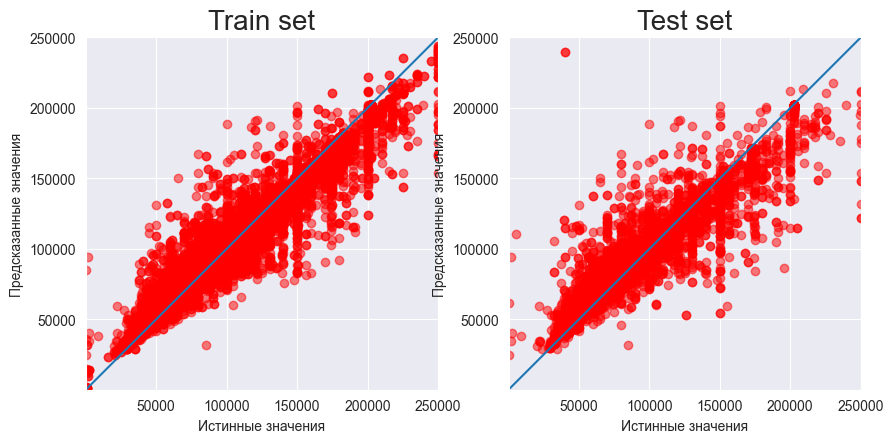

In [57]:
# Определяем RandomForestRegressor
tree = RandomForestRegressor()

# Определяем сетку параметров для поиска по сетке
param_grid = {
    'n_estimators': [100, 200, 300],  # Количество деревьев в лесу
    'max_depth': [None, 10, 20, 30],   # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],   # Минимальное количество выборок, необходимое для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],     # Минимальное количество выборок, необходимое для листового узла
    'max_features': [1, 10, 22, 44, 66, 'sqrt'],  # Количество признаков для рассмотрения при поиске лучшего разделения
}

# Инициализируем GridSearchCV
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Выполняем поиск по сетке на обучающих данных
grid_search.fit(x_train, y_train)

# Выводим лучшие найденные параметры
print("Best parameters found:")
print(grid_search.best_params_)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Предсказываем на тестовом наборе с использованием лучшей модели
y_tree_pred_test = best_model.predict(x_test)
y_tree_pred_train = best_model.predict(x_train)

# Строим результаты, если доступна функция plot_yreal_ypred
visualization.plot_yreal_ypred(y_test, y_train, y_tree_pred_test, y_tree_pred_train)


Видно, что случайный лес работает лучше, ведь зависимость от переменных нелинейна, попробуем выполнить схожую задачу, только рассмотрим это как проблему классификации, где надо предугадать интервал зарплаты смотря на параметры. Пускай каждый интервал будет по 50000.

In [58]:
# делим на интервалы по 50000, [1, 50000] -> 1.0
y = np.ceil(y/50000)

In [59]:
# как выглядят таргеты
y.head()

0    1.0
1    2.0
2    5.0
3    5.0
4    2.0
Name: salary, dtype: float64

In [60]:
# делаем разделение на тренировочную и тестовую выборку, сохраняя пропорции классов одинаковыми в тренировочной и тестовой выборках
x_train, x_test, y_train, y_test = train_test_split(encoded, y, test_size=0.2, random_state=123, stratify=y)

In [61]:
# создаем словари для признаков и таргетов каждой отдельной индустрии
x_test_by_industry = {}
y_test_by_industry = {}

for industry in industry_names:
    # фильтрум данные из определенной индустрии
    mask = x_test[f'industry_{industry}'] == 1.0
    x_test_by_industry[industry] = x_test[mask]
    y_test_by_industry[industry] = y_test[mask]

In [62]:
def get_accuracy_for_industry(model):
    """
    Печатает accuracy для каждой индустрии отдельно для тестовой выборки.
    :param model: Найденная модель.
    :return: None
    """
    for industry in industry_names:
        print(f"Оценка лучшей модели на тестовом {industry}:", model.score(x_test_by_industry[industry], y_test_by_industry[industry]))

In [63]:
# Определяем RandomForestClassifier
forest = RandomForestClassifier(n_estimators=300, random_state=123)

# Определяем сетку параметров для поиска по сетке
param_grid = {
    'n_estimators': [100, 200, 300],          # Количество деревьев в лесу
    'max_depth': [None, 10, 20, 30],          # Максимальная глубина дерева
    'min_samples_split': [2, 5, 10],          # Минимальное количество выборок для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],            # Минимальное количество выборок для листового узла
    'max_features': [1, 10, 22, 44, 66, 'sqrt'],         # Количество признаков для рассмотрения при поиске лучшего разделения

}

# Инициализируем GridSearchCV
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Выполняем поиск по сетке на обучающих данных
grid_search.fit(x_train, y_train)

# Выводим лучшие найденные параметры
print("Лучшие найденные параметры:")
print(grid_search.best_params_)

# Получаем лучшую модель
best_model = grid_search.best_estimator_
score = best_model.score(x_test, y_test)
print("Оценка лучшей модели на тестовом наборе:", score)
get_accuracy_for_industry(best_model)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Лучшие найденные параметры:
{'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Оценка лучшей модели на тестовом наборе: 0.6844827586206896
Оценка лучшей модели на тестовом Автомобильный бизнес: 0.604309500489716
Оценка лучшей модели на тестовом Перевозки, логистика, склад, ВЭД: 0.7231404958677686
Оценка лучшей модели на тестовом Электроника, приборостроение, бытовая техника, компьютеры и оргтехника: 0.6966542750929368


Видно, что случайный лес также хорошо категоризирует данные, средняя accuracy равна 0.6844. Видно, что модель хуже справляется с автомобильным бизнесом.

In [64]:
# Определяем KNeighborsRegressor
knn = KNeighborsRegressor(weights='distance', n_neighbors=250)

# Определяем сетку параметров для поиска по сетке
param_grid = {
    'n_neighbors': [5, 10, 50, 100, 250],  # Количество соседей для учета
    'weights': ['uniform', 'distance'],     # Функция веса, используемая при прогнозировании
}

# Инициализируем GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Выполняем поиск по сетке на обучающих данных
grid_search.fit(x_train, y_train)

# Выводим лучшие найденные параметры
print("Лучшие найденные параметры:")
print(grid_search.best_params_)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Оцениваем лучшую модель на тестовом наборе
score = best_model.score(x_test, y_test)
print("Оценка лучшей модели на тестовом наборе:", score)
get_accuracy_for_industry(best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие найденные параметры:
{'n_neighbors': 50, 'weights': 'distance'}
Оценка лучшей модели на тестовом наборе: 0.5052836745850041
Оценка лучшей модели на тестовом Автомобильный бизнес: 0.3348010209286407
Оценка лучшей модели на тестовом Перевозки, логистика, склад, ВЭД: 0.6402609642122338
Оценка лучшей модели на тестовом Электроника, приборостроение, бытовая техника, компьютеры и оргтехника: 0.26902634037217676


Метод ближайших соседей плохо справляется с двумя отраслями из трех.

In [65]:
param_grid = {
    'penalty': ['l1', 'l2'],                  # регуляризация
    'C': [0.001, 0.01, 0.1, 1, 10, 100],      # Обратная сила регуляризации
    'solver': ['liblinear', 'saga'],          # Алгоритм, используемый в задаче оптимизации
}

logreg = LogisticRegression(max_iter=10000)
# Инициализируем GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Выполняем поиск по сетке на обучающих данных
grid_search.fit(x_train, y_train)

# Выводим лучшие найденные параметры
print("Лучшие найденные параметры:")
print(grid_search.best_params_)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Оцениваем лучшую модель на тестовом наборе
score = best_model.score(x_test, y_test)
print("Оценка лучшей модели на тестовом наборе:", score)
get_accuracy_for_industry(best_model)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Лучшие найденные параметры:
{'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Оценка лучшей модели на тестовом наборе: 0.6184729064039409
Оценка лучшей модели на тестовом Автомобильный бизнес: 0.5612144955925563
Оценка лучшей модели на тестовом Перевозки, логистика, склад, ВЭД: 0.6257378984651711
Оценка лучшей модели на тестовом Электроника, приборостроение, бытовая техника, компьютеры и оргтехника: 0.6527881040892193


Логистическая регрессия справляется хорошо со всеми отраслями, значения accuracy близки по значениям.

In [66]:
# Задать сетку параметров
param_grid = {
    # Указать параметр альфа для сглаживания Лапласа
    'alpha': [0.1, 0.5, 1.0]
}

# Создать классификатор категориального наивного Байеса
bay = CategoricalNB()

# Создать объект GridSearchCV
grid_search_bay = GridSearchCV(bay, param_grid, cv=5)  # 5-кратная перекрестная проверка

# Применить поиск по сетке к данным обучения
grid_search_bay.fit(x_train, y_train)

# Выводим лучшие найденные параметры
best_params = grid_search_bay.best_params_
print("Лучшие найденные параметры:", best_params)

# Оценить лучшую модель на тестовых данных
best_model = grid_search_bay.best_estimator_
score = best_model.score(x_test, y_test)
print("Оценка лучшей модели на тестовом наборе:", score)
get_accuracy_for_industry(best_model)


Лучшие найденные параметры: {'alpha': 0.1}
Оценка лучшей модели на тестовом наборе: 0.5785714285714286
Оценка лучшей модели на тестовом Автомобильный бизнес: 0.5367286973555337
Оценка лучшей модели на тестовом Перевозки, логистика, склад, ВЭД: 0.5525383707201889
Оценка лучшей модели на тестовом Электроника, приборостроение, бытовая техника, компьютеры и оргтехника: 0.6431226765799256


Классификатор категориального наивного Байеса справляется средне, но хорошо справляется с индустрией `Электроника, приборостроение...`

### Выводы

Из протестированных моделей лучше всех справляются случайный лес для регрессии и случайный лес для категоризации. Это может быть связано с нелинейной зависимостью таргета от признаков. Возможно, нейронные сети справятся с этой проблемой лучше.

Говоря про датасет и саму работу с api hh.ru, хотим отметить, что собирание данных является непростой задачей, если надо собрать побольше записей и обработать их. Очень понравилась стадия EDA, рисование графиков и понимание самих данных - очень важный этап в обработке датасета. Проект понравился своей идеей, ведь это реальные данные, собранные только-только, а не готовый датасет 10-летней давности или состоящий из искусственных данных. Работа была планомерна и тщательна.